In [1]:
# !pip install wandb

In [2]:
import ast
import gc
import glob
import json
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import torch
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import sys
from functools import partial

sys.path.append("/app/_data/MONAI")
import monai
import segmentation_models_pytorch as smp
from monai import data
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import CumulativeIterationMetric, DiceMetric
from monai.metrics.utils import (
    do_metric_reduction,
    get_mask_edges,
    get_surface_distance,
)
from monai.networks.nets import SwinUNETR, UNet
from monai.utils import LossReduction
from monai.utils.enums import MetricReduction

Extension horovod.torch has not been built: /usr/local/lib/python3.8/dist-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


In [3]:
!wandb login 2a29d4ea12edef115a98307eee0e9bf7db67b635
import wandb

wandb.init(dir="/app/_data/", project="tract_segmentation_3D")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: tatanko. Use `wandb login --relogin` to force relogin


In [4]:
IMG_SIZE = (224, 224, 80)
BATCH_SIZE = 8

In [5]:
class HausdorffScore(CumulativeIterationMetric):
    """
    Modify MONAI's HausdorffDistanceMetric for Kaggle UW-Madison GI Tract Image Segmentation

    """

    def __init__(
        self,
        reduction="mean",
    ) -> None:
        super().__init__()
        self.reduction = reduction

    def _compute_tensor(self, pred, gt):

        return compute_hausdorff_score(pred, gt)

    def aggregate(self):
        """
        Execute reduction logic for the output of `compute_hausdorff_distance`.

        """
        data = self.get_buffer()
        # do metric reduction
        f, _ = do_metric_reduction(data, self.reduction)
        return f


def compute_directed_hausdorff(pred, gt, max_dist):
    if np.all(pred == gt):
        return 0.0
    if np.sum(pred) == 0:
        return 1.0
    if np.sum(gt) == 0:
        return 1.0
    (edges_pred, edges_gt) = get_mask_edges(pred, gt)
    surface_distance = get_surface_distance(
        edges_pred, edges_gt, distance_metric="euclidean"
    )
    if surface_distance.shape == (0,):
        return 0.0
    dist = surface_distance.max()

    if dist > max_dist:
        return 1.0
    return dist / max_dist


def compute_hausdorff_score(pred, gt):

    y = gt.float().to("cpu").numpy()
    y_pred = pred.float().to("cpu").numpy()

    # hausdorff distance score
    batch_size, n_class = y_pred.shape[:2]
    spatial_size = y_pred.shape[2:]
    max_dist = np.sqrt(np.sum([l**2 for l in spatial_size]))
    hd_score = np.empty((batch_size, n_class))
    for b, c in np.ndindex(batch_size, n_class):
        hd_score[b, c] = 1 - compute_directed_hausdorff(y_pred[b, c], y[b, c], max_dist)

    return torch.from_numpy(hd_score)

In [6]:
df = pd.read_csv("/app/data_3d_info.csv")
FOLD = 1
train_df = df[df["fold"] != FOLD]
val_df = df[df["fold"] == FOLD]
train_data = [
    {"image": x, "label": y} for x, y in train_df[["image_path", "mask_path"]].values
]
val_data = [
    {"image": x, "label": y} for x, y in val_df[["image_path", "mask_path"]].values
]

In [7]:
train_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(
            keys=["image", "label"],
        ),
        monai.transforms.AddChanneld(keys="image"),
        monai.transforms.Transposed(
            keys="label", indices=[3, 0, 1, 2]
        ),  # h, w, d, c to c, h, w, d
        monai.transforms.RandSpatialCropd(
            keys=("image", "label"),
            roi_size=IMG_SIZE,
            random_size=False,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        monai.transforms.RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        monai.transforms.RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        monai.transforms.OneOf(
            [
                monai.transforms.RandGridDistortiond(
                    keys=["image", "label"],
                    prob=0.2,
                    distort_limit=(-0.05, 0.05),
                    mode="nearest",
                    padding_mode="zeros",
                ),
                monai.transforms.RandAffined(
                    keys=["image", "label"],
                    prob=0.2,
                    rotate_range=np.pi / 12,
                    translate_range=(IMG_SIZE[0] * 0.0625, IMG_SIZE[0] * 0.0625),
                    scale_range=(0.1, 0.1),
                    mode="nearest",
                    padding_mode="zeros",
                ),
            ],
        ),
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(
            keys=["image", "label"],
        ),
        monai.transforms.AddChanneld(keys="image"),
        monai.transforms.Transposed(
            keys="label", indices=[3, 0, 1, 2]
        ),  # h, w, d, c to c, h, w, d
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [8]:
train_ds = monai.data.CacheDataset(
    data=train_data,
    transform=train_transforms,
    cache_num=16,
    cache_rate=1.0,
    num_workers=None,
)
val_ds = monai.data.CacheDataset(
    data=val_data,
    transform=val_transforms,
    cache_num=16,
    cache_rate=1.0,
    num_workers=None,
)

Loading dataset: 100% 16/16 [00:09<00:00,  1.60it/s]
Loading dataset: 100% 16/16 [00:07<00:00,  2.02it/s]


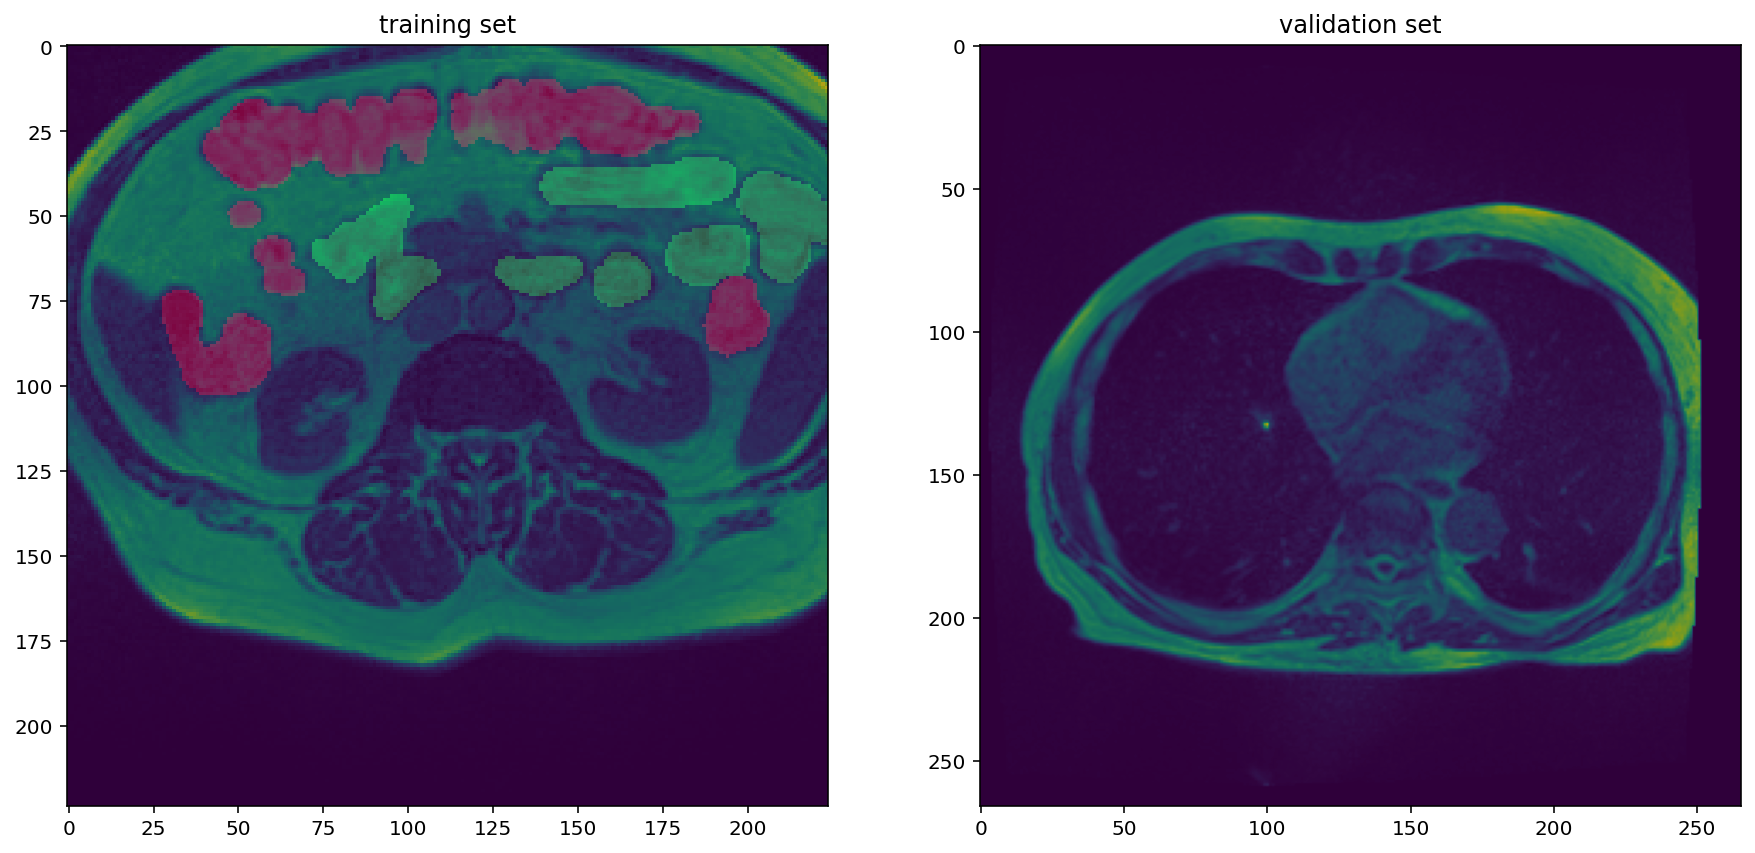

In [9]:
ix, i = 2, 49
img = train_ds[ix]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("training set")
plt.imshow(img["image"].numpy()[0, :, :, i])
plt.imshow(img["label"].numpy()[:, :, :, i].transpose(1, 2, 0), alpha=0.3)
img = val_ds[ix]
plt.subplot(1, 2, 2)
plt.title("validation set")
plt.imshow(img["image"].numpy()[0, :, :, i])
plt.imshow(img["label"].numpy()[:, :, :, i].transpose(1, 2, 0), alpha=0.3)
plt.show();

In [10]:
train_loader = monai.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = monai.data.DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

## model

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size=3,
    up_kernel_size=3,
    num_res_units=2,
    act="PRELU",
    norm="INSTANCE",
    dropout=0.1,
    bias=True,
    dimensions=None,
).to(device)


torch.backends.cudnn.benchmark = True

In [14]:
model.load_state_dict(torch.load("/app/_data/3Dmodels/unet_224_80/best_dice_9279.pth"))

<All keys matched successfully>

In [15]:
loss_fn = monai.losses.DiceLoss(
    sigmoid=True,
    smooth_nr=0.001,
    smooth_dr=0.001,
    include_background=True,
    batch=True,
    squared_pred=False,
)


def dice_score(y_true, y_pred, thres=0.5, dim=(-2, -1), empty=1, eps=0.00001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred >= thres).to(torch.float32)
    intersection = 2 * (y_true * y_pred).sum(dim=dim)
    masks_sum = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    if empty == 1:
        # when y_true[n] is empty and y_pred[n] also empty, dice[n] = 1
        dice = ((intersection + eps) / (masks_sum + eps)).mean()
    else:
        # when y_true[n] is empty and y_pred[n] also empty, dice[n] = 0
        dice = ((intersection) / (masks_sum + eps)).mean()
    return dice


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=200,
    eta_min=0.00001,
)
hausdorff_metric = HausdorffScore(reduction="mean")

In [16]:
def train_one_epoch(model, train_loader, optimizer, scheduler, device, loss_fn, epoch):
    model.train()
    running_loss = 0
    train_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Train: epoch #{epoch + 1}",
        dynamic_ncols=True,
    )
    for step, batch in train_bar:
        step += 1
        optimizer.zero_grad()
        x, y = batch["image"].to(device), batch["label"].to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        current_lr = optimizer.param_groups[0]["lr"]
        memory = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
        train_bar.set_postfix(
            train_loss=f"{running_loss/step:0.4f}",
            lr=f"{current_lr:0.6f}",
            gpu_memory=f"{memory:0.2f} GB",
        )

    scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()
    return running_loss / step

In [17]:
def validate(model, val_loader, device, epoch, img_size, loss_fn):
    dice = 0
    loss = 0
    model.eval()
    val_bar = tqdm(
        enumerate(val_loader),
        total=len(val_loader),
        desc=f"Val:   epoch #{epoch + 1}",
    )

    for step, batch in val_bar:
        val_inputs, val_labels = batch["image"].to(device), batch["label"].to(device)
        with torch.no_grad():
            val_outputs = sliding_window_inference(val_inputs, img_size, 1, model)
            loss += loss_fn(val_outputs, val_labels).item()
        val_outputs = torch.nn.Sigmoid()(val_outputs)
        val_outputs = torch.where(val_outputs > 0.5, 1, 0)
        dice += (
            dice_score(
                val_labels, val_outputs, thres=0.5, dim=(-3, -2), empty=1, eps=0.00001
            )
            .cpu()
            .numpy()
        )
        val_outputs = val_outputs.permute([0, 4, 1, 2, 3]).flatten(0, 1)
        val_labels = val_labels.permute([0, 4, 1, 2, 3]).flatten(0, 1)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        del val_outputs, val_inputs, val_labels, batch
    dice = dice / len(val_loader)
    loss = loss / len(val_loader)
    hausdorff_score = hausdorff_metric.aggregate().item()
    hausdorff_metric.reset()
    weighted_score = dice * 0.4 + hausdorff_score * 0.6
    print(
        f"dice_score: {dice} hausdorff_score: {hausdorff_score} all_score: {weighted_score}"
    )
    torch.cuda.empty_cache()
    gc.collect()
    val_scores = {
        "dice": dice,
        "loss": loss,
        "hausdorff_score": hausdorff_score,
        "weighted_score": weighted_score,
    }
    return val_scores

In [35]:
n_epoch = 1000
best_dice = 0
best_weighted_score = 0
best_dice_epoch = 0
best_cum_epoch = 0
path = "/app/_data/3Dmodels/unet_224_80_f1_my"
os.makedirs(path, exist_ok=True)
scores = {
    "train_loss": [],
    "val_loss": [],
    "dice": [],
    "hausdorff_score": [],
    "weighted_score": [],
}
for epoch in range(n_epoch):
    wandb.watch(model, log_freq=10)
    train_loss = train_one_epoch(
        model, train_loader, optimizer, scheduler, device, loss_fn, epoch
    )
    torch.save(model.state_dict(), os.path.join(path, "last.pth"))

    val_scores = validate(
        model, val_loader, device, epoch, img_size=IMG_SIZE, loss_fn=loss_fn
    )
    dice = val_scores["dice"]
    hausdorff_score = val_scores["hausdorff_score"]
    weighted_score = val_scores["weighted_score"]
    scores["dice"].append(dice)
    scores["hausdorff_score"].append(hausdorff_score)
    scores["weighted_score"].append(weighted_score)
    scores["val_loss"].append(val_scores["loss"])
    scores["train_loss"].append(train_loss)
    wandb.log(
        {
            "Train Loss": train_loss,
            "Valid Loss": val_scores["loss"],
            "Valid Dice": dice,
            "Valid HD": hausdorff_score,
            "Valid weighted_score": weighted_score,
            "LR": scheduler.get_last_lr()[0],
        }
    )
    if dice > best_dice:
        best_dice_epoch = epoch
        torch.save(model.state_dict(), os.path.join(path, "best_dice.pth"))
        print(
            f"Dice improved from {best_dice:0.4f} to {dice:0.4f}, model was saved at {os.path.join(path, 'best_dice.pth')}"
        )
        best_dice = dice
    if weighted_score > best_weighted_score:
        best_cum_epoch = epoch
        torch.save(model.state_dict(), os.path.join(path, "best_all.pth"))
        print(
            f"best_cum_metric improved from {best_weighted_score:0.4f} to {weighted_score:0.4f}, model was saved at {os.path.join(path, 'best_all.pth')}"
        )
        best_weighted_score = weighted_score
    torch.save(model.state_dict(), os.path.join(path, "last.pth"))
    with open(os.path.join(path, "history.json"), "w") as f:
        json.dump(scores, f)

[]

Train: epoch #1: 100% 29/29 [04:50<00:00, 10.01s/it, gpu_memory=14.85 GB, lr=0.000202, train_loss=0.1005]
Val:   epoch #1: 100% 42/42 [01:22<00:00,  1.96s/it]


dice_score: 0.9230021366051265 hausdorff_score: 0.9628211871468799 all_score: 0.9468935669301786
Dice improved from 0.0000 to 0.9230, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth
best_cum_metric improved from 0.0000 to 0.9469, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #2: 100% 29/29 [04:53<00:00, 10.11s/it, gpu_memory=14.85 GB, lr=0.000196, train_loss=0.1027]
Val:   epoch #2: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.923819343249003 hausdorff_score: 0.9629146964716245 all_score: 0.9472765551825759
Dice improved from 0.9230 to 0.9238, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth
best_cum_metric improved from 0.9469 to 0.9473, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #3: 100% 29/29 [04:52<00:00, 10.10s/it, gpu_memory=14.85 GB, lr=0.000189, train_loss=0.1045]
Val:   epoch #3: 100% 42/42 [01:22<00:00,  1.95s/it]


dice_score: 0.923179322764987 hausdorff_score: 0.9619314527852324 all_score: 0.9464306007771343


[]

Train: epoch #4: 100% 29/29 [04:54<00:00, 10.15s/it, gpu_memory=14.85 GB, lr=0.000184, train_loss=0.1033]
Val:   epoch #4: 100% 42/42 [01:21<00:00,  1.93s/it]


dice_score: 0.9237318847860608 hausdorff_score: 0.9637479031787782 all_score: 0.9477414958216913
best_cum_metric improved from 0.9473 to 0.9477, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #5: 100% 29/29 [04:53<00:00, 10.13s/it, gpu_memory=14.85 GB, lr=0.000178, train_loss=0.1036]
Val:   epoch #5: 100% 42/42 [01:19<00:00,  1.90s/it]


dice_score: 0.923124604281925 hausdorff_score: 0.9625394971961149 all_score: 0.9467735400304389


[]

Train: epoch #6: 100% 29/29 [04:45<00:00,  9.86s/it, gpu_memory=14.85 GB, lr=0.000172, train_loss=0.1020]
Val:   epoch #6: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9239727159341177 hausdorff_score: 0.9630003141839445 all_score: 0.9473892748840137
Dice improved from 0.9238 to 0.9240, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth


[]

Train: epoch #7: 100% 29/29 [04:42<00:00,  9.74s/it, gpu_memory=14.85 GB, lr=0.000166, train_loss=0.1047]
Val:   epoch #7: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9237436183861324 hausdorff_score: 0.9630511838617856 all_score: 0.9473281576715243


[]

Train: epoch #8: 100% 29/29 [04:46<00:00,  9.86s/it, gpu_memory=14.85 GB, lr=0.000161, train_loss=0.1026]
Val:   epoch #8: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9223713207812536 hausdorff_score: 0.9615513240930211 all_score: 0.9458793227683141


[]

Train: epoch #9: 100% 29/29 [04:47<00:00,  9.90s/it, gpu_memory=14.85 GB, lr=0.000155, train_loss=0.1026]
Val:   epoch #9: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9240552045050121 hausdorff_score: 0.9637803269014905 all_score: 0.9478902779428992
Dice improved from 0.9240 to 0.9241, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth
best_cum_metric improved from 0.9477 to 0.9479, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #10: 100% 29/29 [04:51<00:00, 10.04s/it, gpu_memory=14.85 GB, lr=0.000150, train_loss=0.1008]
Val:   epoch #10: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9240728716055552 hausdorff_score: 0.9634034007796636 all_score: 0.9476711891100202
Dice improved from 0.9241 to 0.9241, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth


[]

Train: epoch #11: 100% 29/29 [04:51<00:00, 10.04s/it, gpu_memory=14.85 GB, lr=0.000144, train_loss=0.1037]
Val:   epoch #11: 100% 42/42 [01:17<00:00,  1.83s/it]


dice_score: 0.9225253704048338 hausdorff_score: 0.9618668240966187 all_score: 0.9461302426199047


[]

Train: epoch #12: 100% 29/29 [04:38<00:00,  9.62s/it, gpu_memory=14.85 GB, lr=0.000139, train_loss=0.1022]
Val:   epoch #12: 100% 42/42 [01:12<00:00,  1.72s/it]


dice_score: 0.9233560349260058 hausdorff_score: 0.9622538949280269 all_score: 0.9466947509272184


[]

Train: epoch #13: 100% 29/29 [04:56<00:00, 10.23s/it, gpu_memory=14.85 GB, lr=0.000134, train_loss=0.1029]
Val:   epoch #13: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9212544716539837 hausdorff_score: 0.9605506802126577 all_score: 0.9448321967891882


[]

Train: epoch #14: 100% 29/29 [04:51<00:00, 10.05s/it, gpu_memory=14.85 GB, lr=0.000129, train_loss=0.1046]
Val:   epoch #14: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.922176392305465 hausdorff_score: 0.9611594003085587 all_score: 0.9455661971073213


[]

Train: epoch #15: 100% 29/29 [04:50<00:00, 10.00s/it, gpu_memory=14.85 GB, lr=0.000124, train_loss=0.1032]
Val:   epoch #15: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9229958823748997 hausdorff_score: 0.9621383767346857 all_score: 0.9464813789907713


[]

Train: epoch #16: 100% 29/29 [04:49<00:00, 10.00s/it, gpu_memory=14.85 GB, lr=0.000119, train_loss=0.1016]
Val:   epoch #16: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9236413737138113 hausdorff_score: 0.963401151420237 all_score: 0.9474972403376667


[]

Train: epoch #17: 100% 29/29 [04:38<00:00,  9.61s/it, gpu_memory=14.85 GB, lr=0.000114, train_loss=0.1017]
Val:   epoch #17: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9227548738320669 hausdorff_score: 0.9616772014948686 all_score: 0.9461082704297479


[]

Train: epoch #18: 100% 29/29 [04:53<00:00, 10.12s/it, gpu_memory=14.85 GB, lr=0.000109, train_loss=0.1020]
Val:   epoch #18: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.921739270289739 hausdorff_score: 0.9609085184346002 all_score: 0.9452408191766557


[]

Train: epoch #19: 100% 29/29 [04:54<00:00, 10.14s/it, gpu_memory=14.85 GB, lr=0.000105, train_loss=0.1022]
Val:   epoch #19: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9234564900398254 hausdorff_score: 0.9628482911444133 all_score: 0.9470915707025782


[]

Train: epoch #20: 100% 29/29 [04:52<00:00, 10.08s/it, gpu_memory=14.85 GB, lr=0.000100, train_loss=0.1008]
Val:   epoch #20: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9226326431546893 hausdorff_score: 0.961813258927427 all_score: 0.946141012618332


[]

Train: epoch #21: 100% 29/29 [04:52<00:00, 10.07s/it, gpu_memory=14.85 GB, lr=0.000096, train_loss=0.1018]
Val:   epoch #21: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9234574706781478 hausdorff_score: 0.9625690223472326 all_score: 0.9469244016795987


[]

Train: epoch #22: 100% 29/29 [04:50<00:00, 10.00s/it, gpu_memory=14.85 GB, lr=0.000091, train_loss=0.1002]
Val:   epoch #22: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9227900703748068 hausdorff_score: 0.9619328021583969 all_score: 0.9462757094449609


[]

Train: epoch #23: 100% 29/29 [04:44<00:00,  9.81s/it, gpu_memory=14.85 GB, lr=0.000087, train_loss=0.1022]
Val:   epoch #23: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9236704040141333 hausdorff_score: 0.9629751465207406 all_score: 0.9472532495180976


[]

Train: epoch #24: 100% 29/29 [04:51<00:00, 10.06s/it, gpu_memory=14.85 GB, lr=0.000083, train_loss=0.1017]
Val:   epoch #24: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9230036210446131 hausdorff_score: 0.9623493175371913 all_score: 0.9466110389401601


[]

Train: epoch #25: 100% 29/29 [04:53<00:00, 10.13s/it, gpu_memory=14.85 GB, lr=0.000079, train_loss=0.1008]
Val:   epoch #25: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9239414575554076 hausdorff_score: 0.9636009404208535 all_score: 0.9477371472746752


[]

Train: epoch #26: 100% 29/29 [04:52<00:00, 10.08s/it, gpu_memory=14.85 GB, lr=0.000075, train_loss=0.1007]
Val:   epoch #26: 100% 42/42 [01:17<00:00,  1.83s/it]


dice_score: 0.9225489681675321 hausdorff_score: 0.9619350374063637 all_score: 0.946180609710831


[]

Train: epoch #27: 100% 29/29 [04:43<00:00,  9.78s/it, gpu_memory=14.85 GB, lr=0.000071, train_loss=0.1005]
Val:   epoch #27: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9232503956272489 hausdorff_score: 0.9623144466766478 all_score: 0.9466888262568882


[]

Train: epoch #28: 100% 29/29 [04:48<00:00,  9.93s/it, gpu_memory=14.85 GB, lr=0.000068, train_loss=0.1026]
Val:   epoch #28: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9227180452573867 hausdorff_score: 0.9618245039255706 all_score: 0.9461819204582971


[]

Train: epoch #29: 100% 29/29 [04:49<00:00,  9.98s/it, gpu_memory=14.85 GB, lr=0.000064, train_loss=0.1006]
Val:   epoch #29: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9225754695279258 hausdorff_score: 0.9615022848723754 all_score: 0.9459315587345956


[]

Train: epoch #30: 100% 29/29 [04:51<00:00, 10.07s/it, gpu_memory=14.85 GB, lr=0.000060, train_loss=0.0992]
Val:   epoch #30: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9242386633441562 hausdorff_score: 0.9632834267057186 all_score: 0.9476655213610937
Dice improved from 0.9241 to 0.9242, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth


[]

Train: epoch #31: 100% 29/29 [04:54<00:00, 10.15s/it, gpu_memory=14.85 GB, lr=0.000057, train_loss=0.1015]
Val:   epoch #31: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9237232577233088 hausdorff_score: 0.9630339131633253 all_score: 0.9473096509873187


[]

Train: epoch #32: 100% 29/29 [04:50<00:00, 10.03s/it, gpu_memory=14.85 GB, lr=0.000054, train_loss=0.1009]
Val:   epoch #32: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9236490300723484 hausdorff_score: 0.9633231905053616 all_score: 0.9474535263321564


[]

Train: epoch #33: 100% 29/29 [04:42<00:00,  9.74s/it, gpu_memory=14.85 GB, lr=0.000051, train_loss=0.1024]
Val:   epoch #33: 100% 42/42 [01:13<00:00,  1.75s/it]


dice_score: 0.9233567416667938 hausdorff_score: 0.9628414345770112 all_score: 0.9470475574129242


[]

Train: epoch #34: 100% 29/29 [04:51<00:00, 10.05s/it, gpu_memory=14.85 GB, lr=0.000048, train_loss=0.1001]
Val:   epoch #34: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.924207295690264 hausdorff_score: 0.9634293382120359 all_score: 0.9477405212033272


[]

Train: epoch #35: 100% 29/29 [04:52<00:00, 10.09s/it, gpu_memory=14.85 GB, lr=0.000045, train_loss=0.1018]
Val:   epoch #35: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9225682332402184 hausdorff_score: 0.9614568546145741 all_score: 0.9459014060648319


[]

Train: epoch #36: 100% 29/29 [04:54<00:00, 10.16s/it, gpu_memory=14.85 GB, lr=0.000042, train_loss=0.1005]
Val:   epoch #36: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9240419339566004 hausdorff_score: 0.9634659251535118 all_score: 0.9476963286747473


[]

Train: epoch #37: 100% 29/29 [04:53<00:00, 10.11s/it, gpu_memory=14.85 GB, lr=0.000039, train_loss=0.1010]
Val:   epoch #37: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9238966022218976 hausdorff_score: 0.9633885669740233 all_score: 0.9475917810731731


[]

Train: epoch #38: 100% 29/29 [04:52<00:00, 10.08s/it, gpu_memory=14.85 GB, lr=0.000037, train_loss=0.1024]
Val:   epoch #38: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.923382831471307 hausdorff_score: 0.9626080955320253 all_score: 0.946917989907738


[]

Train: epoch #39: 100% 29/29 [04:52<00:00, 10.09s/it, gpu_memory=14.85 GB, lr=0.000034, train_loss=0.1038]
Val:   epoch #39: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9237486138230279 hausdorff_score: 0.9631990417658325 all_score: 0.9474188705887105


[]

Train: epoch #40: 100% 29/29 [04:51<00:00, 10.07s/it, gpu_memory=14.85 GB, lr=0.000032, train_loss=0.1017]
Val:   epoch #40: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9234821299711863 hausdorff_score: 0.9625823949586761 all_score: 0.9469422889636803


[]

Train: epoch #41: 100% 29/29 [04:53<00:00, 10.10s/it, gpu_memory=14.85 GB, lr=0.000030, train_loss=0.1013]
Val:   epoch #41: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9229396737757183 hausdorff_score: 0.9621598896360892 all_score: 0.9464718032919409


[]

Train: epoch #42: 100% 29/29 [04:56<00:00, 10.23s/it, gpu_memory=14.85 GB, lr=0.000028, train_loss=0.1027]
Val:   epoch #42: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9233662429310027 hausdorff_score: 0.9626889737913946 all_score: 0.9469598814472379


[]

Train: epoch #43: 100% 29/29 [04:50<00:00, 10.02s/it, gpu_memory=14.85 GB, lr=0.000026, train_loss=0.1016]
Val:   epoch #43: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9233154697077615 hausdorff_score: 0.962470683529549 all_score: 0.9468085980008341


[]

Train: epoch #44: 100% 29/29 [04:53<00:00, 10.11s/it, gpu_memory=14.85 GB, lr=0.000024, train_loss=0.1053]
Val:   epoch #44: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9235657226471674 hausdorff_score: 0.9630184943965598 all_score: 0.9472373856968028


[]

Train: epoch #45: 100% 29/29 [04:54<00:00, 10.15s/it, gpu_memory=14.85 GB, lr=0.000022, train_loss=0.1011]
Val:   epoch #45: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9234226189908528 hausdorff_score: 0.9625583483689802 all_score: 0.9469040566177293


[]

Train: epoch #46: 100% 29/29 [04:55<00:00, 10.18s/it, gpu_memory=14.85 GB, lr=0.000020, train_loss=0.1036]
Val:   epoch #46: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.923658800976617 hausdorff_score: 0.9628585057924158 all_score: 0.9471786238660964


[]

Train: epoch #47: 100% 29/29 [04:56<00:00, 10.23s/it, gpu_memory=14.85 GB, lr=0.000019, train_loss=0.1003]
Val:   epoch #47: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.923511300768171 hausdorff_score: 0.9626184399601546 all_score: 0.9469755842833611


[]

Train: epoch #48: 100% 29/29 [04:47<00:00,  9.92s/it, gpu_memory=14.85 GB, lr=0.000017, train_loss=0.1017]
Val:   epoch #48: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9235711949212211 hausdorff_score: 0.9627062904080987 all_score: 0.9470522522133477


[]

Train: epoch #49: 100% 29/29 [04:54<00:00, 10.16s/it, gpu_memory=14.85 GB, lr=0.000016, train_loss=0.1023]
Val:   epoch #49: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9233650409039997 hausdorff_score: 0.9626797313951931 all_score: 0.9469538551987158


[]

Train: epoch #50: 100% 29/29 [04:54<00:00, 10.16s/it, gpu_memory=14.85 GB, lr=0.000015, train_loss=0.1014]
Val:   epoch #50: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9234672415824163 hausdorff_score: 0.9625009925386814 all_score: 0.9468874921561753


[]

Train: epoch #51: 100% 29/29 [04:53<00:00, 10.12s/it, gpu_memory=14.85 GB, lr=0.000014, train_loss=0.0992]
Val:   epoch #51: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9234628620601836 hausdorff_score: 0.9625433056729431 all_score: 0.9469111282278393


[]

Train: epoch #52: 100% 29/29 [04:56<00:00, 10.21s/it, gpu_memory=14.85 GB, lr=0.000013, train_loss=0.1014]
Val:   epoch #52: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9233752134300414 hausdorff_score: 0.9624561934248066 all_score: 0.9468238014269006


[]

Train: epoch #53: 100% 29/29 [04:48<00:00,  9.96s/it, gpu_memory=14.85 GB, lr=0.000012, train_loss=0.0994]
Val:   epoch #53: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9234520892302195 hausdorff_score: 0.9626440276512612 all_score: 0.9469672522828445


[]

Train: epoch #54: 100% 29/29 [04:49<00:00, 10.00s/it, gpu_memory=14.85 GB, lr=0.000012, train_loss=0.1000]
Val:   epoch #54: 100% 42/42 [01:14<00:00,  1.76s/it]


dice_score: 0.9237465801693144 hausdorff_score: 0.9628773905631731 all_score: 0.9472250664056296


[]

Train: epoch #55: 100% 29/29 [04:56<00:00, 10.21s/it, gpu_memory=14.85 GB, lr=0.000011, train_loss=0.0998]
Val:   epoch #55: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9234441845189958 hausdorff_score: 0.9624770601740511 all_score: 0.946863909912029


[]

Train: epoch #56: 100% 29/29 [05:00<00:00, 10.36s/it, gpu_memory=14.85 GB, lr=0.000011, train_loss=0.1016]
Val:   epoch #56: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9237362855956668 hausdorff_score: 0.9629197373570659 all_score: 0.9472463566525062


[]

Train: epoch #57: 100% 29/29 [04:52<00:00, 10.08s/it, gpu_memory=14.85 GB, lr=0.000010, train_loss=0.1013]
Val:   epoch #57: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9235693656262898 hausdorff_score: 0.9627275340380769 all_score: 0.947064266673362


[]

Train: epoch #58: 100% 29/29 [04:55<00:00, 10.21s/it, gpu_memory=14.85 GB, lr=0.000010, train_loss=0.1005]
Val:   epoch #58: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9233544369538625 hausdorff_score: 0.962350392440954 all_score: 0.9467520102461174


[]

Train: epoch #59: 100% 29/29 [04:53<00:00, 10.12s/it, gpu_memory=14.85 GB, lr=0.000010, train_loss=0.1006]
Val:   epoch #59: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.9235128249440875 hausdorff_score: 0.9624677075541661 all_score: 0.9468857545101346


[]

Train: epoch #60: 100% 29/29 [04:51<00:00, 10.04s/it, gpu_memory=14.85 GB, lr=0.000010, train_loss=0.1021]
Val:   epoch #60: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9235167361441112 hausdorff_score: 0.9626031666672273 all_score: 0.9469685944579809


[]

Train: epoch #61: 100% 29/29 [04:51<00:00, 10.06s/it, gpu_memory=14.85 GB, lr=0.000010, train_loss=0.0992]
Val:   epoch #61: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.923894886459623 hausdorff_score: 0.9630158348148916 all_score: 0.9473674554727841


[]

Train: epoch #62: 100% 29/29 [04:53<00:00, 10.11s/it, gpu_memory=14.85 GB, lr=0.000011, train_loss=0.0993]
Val:   epoch #62: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.9237266182899475 hausdorff_score: 0.9629561917789344 all_score: 0.9472643623833397


[]

Train: epoch #63: 100% 29/29 [04:48<00:00,  9.95s/it, gpu_memory=14.85 GB, lr=0.000011, train_loss=0.1008]
Val:   epoch #63: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9234777348382133 hausdorff_score: 0.9623992171418866 all_score: 0.9468306242204173


[]

Train: epoch #64: 100% 29/29 [04:51<00:00, 10.03s/it, gpu_memory=14.85 GB, lr=0.000012, train_loss=0.1008]
Val:   epoch #64: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.9236664913949513 hausdorff_score: 0.9627204032951767 all_score: 0.9470988385350866


[]

Train: epoch #65: 100% 29/29 [04:49<00:00, 10.00s/it, gpu_memory=14.85 GB, lr=0.000012, train_loss=0.0990]
Val:   epoch #65: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9234653725510552 hausdorff_score: 0.962622188625891 all_score: 0.9469594621959567


[]

Train: epoch #66: 100% 29/29 [04:52<00:00, 10.07s/it, gpu_memory=14.85 GB, lr=0.000013, train_loss=0.0978]
Val:   epoch #66: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9235801895459493 hausdorff_score: 0.962688497383551 all_score: 0.9470451742485103


[]

Train: epoch #67: 100% 29/29 [04:55<00:00, 10.17s/it, gpu_memory=14.85 GB, lr=0.000014, train_loss=0.1012]
Val:   epoch #67: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9239128813857124 hausdorff_score: 0.9628232554612994 all_score: 0.9472591058310647


[]

Train: epoch #68: 100% 29/29 [05:01<00:00, 10.40s/it, gpu_memory=14.85 GB, lr=0.000015, train_loss=0.1014]
Val:   epoch #68: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9236062169075012 hausdorff_score: 0.9625594595919795 all_score: 0.9469781625181882


[]

Train: epoch #69: 100% 29/29 [04:53<00:00, 10.11s/it, gpu_memory=14.85 GB, lr=0.000016, train_loss=0.1015]
Val:   epoch #69: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9234304158460527 hausdorff_score: 0.9624916939520146 all_score: 0.9468671827096298


[]

Train: epoch #70: 100% 29/29 [04:55<00:00, 10.20s/it, gpu_memory=14.85 GB, lr=0.000017, train_loss=0.1003]
Val:   epoch #70: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9235175280343919 hausdorff_score: 0.9625946443436764 all_score: 0.9469637978199625


[]

Train: epoch #71: 100% 29/29 [04:57<00:00, 10.25s/it, gpu_memory=14.85 GB, lr=0.000019, train_loss=0.1028]
Val:   epoch #71: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9238083064556122 hausdorff_score: 0.9628004979689246 all_score: 0.9472036213635997


[]

Train: epoch #72: 100% 29/29 [04:58<00:00, 10.29s/it, gpu_memory=14.85 GB, lr=0.000020, train_loss=0.1024]
Val:   epoch #72: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9239263988676525 hausdorff_score: 0.963169786947542 all_score: 0.9474724317155863


[]

Train: epoch #73: 100% 29/29 [04:59<00:00, 10.34s/it, gpu_memory=14.85 GB, lr=0.000022, train_loss=0.1038]
Val:   epoch #73: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9233344921043941 hausdorff_score: 0.9622616831984276 all_score: 0.9466908067608142


[]

Train: epoch #74: 100% 29/29 [04:56<00:00, 10.22s/it, gpu_memory=14.85 GB, lr=0.000024, train_loss=0.1011]
Val:   epoch #74: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9235553187983376 hausdorff_score: 0.9625928979296036 all_score: 0.9469778662770971


[]

Train: epoch #75: 100% 29/29 [04:50<00:00, 10.03s/it, gpu_memory=14.85 GB, lr=0.000026, train_loss=0.1014]
Val:   epoch #75: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9234760999679565 hausdorff_score: 0.9629189136122931 all_score: 0.9471417881545585


[]

Train: epoch #76: 100% 29/29 [04:56<00:00, 10.22s/it, gpu_memory=14.85 GB, lr=0.000028, train_loss=0.1000]
Val:   epoch #76: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9231270466532026 hausdorff_score: 0.9621664618373093 all_score: 0.9465506957636666


[]

Train: epoch #77: 100% 29/29 [05:00<00:00, 10.36s/it, gpu_memory=14.85 GB, lr=0.000030, train_loss=0.1018]
Val:   epoch #77: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9231343822819846 hausdorff_score: 0.9622243554860117 all_score: 0.9465883662044008


[]

Train: epoch #78: 100% 29/29 [04:58<00:00, 10.31s/it, gpu_memory=14.85 GB, lr=0.000032, train_loss=0.1015]
Val:   epoch #78: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9241800421760196 hausdorff_score: 0.9632465014712588 all_score: 0.9476199177531631


[]

Train: epoch #79: 100% 29/29 [04:57<00:00, 10.26s/it, gpu_memory=14.85 GB, lr=0.000034, train_loss=0.1004]
Val:   epoch #79: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9235494888964153 hausdorff_score: 0.9629589779944739 all_score: 0.9471951823552505


[]

Train: epoch #80: 100% 29/29 [04:53<00:00, 10.12s/it, gpu_memory=14.85 GB, lr=0.000037, train_loss=0.1001]
Val:   epoch #80: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9235646015121823 hausdorff_score: 0.9627332295059884 all_score: 0.9470657783084659


[]

Train: epoch #81: 100% 29/29 [04:58<00:00, 10.30s/it, gpu_memory=14.85 GB, lr=0.000039, train_loss=0.0993]
Val:   epoch #81: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.9235903336888268 hausdorff_score: 0.9629323040136263 all_score: 0.9471955158837064


[]

Train: epoch #82: 100% 29/29 [05:01<00:00, 10.39s/it, gpu_memory=14.85 GB, lr=0.000042, train_loss=0.1005]
Val:   epoch #82: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9239081044991811 hausdorff_score: 0.9632464574395708 all_score: 0.947511116263415


[]

Train: epoch #83: 100% 29/29 [04:58<00:00, 10.28s/it, gpu_memory=14.85 GB, lr=0.000045, train_loss=0.1024]
Val:   epoch #83: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9227867467062814 hausdorff_score: 0.961666494220583 all_score: 0.9461145952148624


[]

Train: epoch #84: 100% 29/29 [05:00<00:00, 10.37s/it, gpu_memory=14.85 GB, lr=0.000048, train_loss=0.1006]
Val:   epoch #84: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.92279594710895 hausdorff_score: 0.9618131546826544 all_score: 0.9462062716531726


[]

Train: epoch #85: 100% 29/29 [04:50<00:00, 10.03s/it, gpu_memory=14.85 GB, lr=0.000051, train_loss=0.1020]
Val:   epoch #85: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9236023198990595 hausdorff_score: 0.9630251895715949 all_score: 0.9472560417025807


[]

Train: epoch #86: 100% 29/29 [04:58<00:00, 10.31s/it, gpu_memory=14.85 GB, lr=0.000054, train_loss=0.1031]
Val:   epoch #86: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9241206858839307 hausdorff_score: 0.9635692299300845 all_score: 0.947789812311623


[]

Train: epoch #87: 100% 29/29 [04:56<00:00, 10.23s/it, gpu_memory=14.85 GB, lr=0.000057, train_loss=0.1008]
Val:   epoch #87: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9232399889401027 hausdorff_score: 0.9624606171164938 all_score: 0.9467723658459374


[]

Train: epoch #88: 100% 29/29 [04:59<00:00, 10.34s/it, gpu_memory=14.85 GB, lr=0.000060, train_loss=0.1004]
Val:   epoch #88: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9229908727464222 hausdorff_score: 0.9622567941754653 all_score: 0.9465504256038481


[]

Train: epoch #89: 100% 29/29 [04:58<00:00, 10.28s/it, gpu_memory=14.85 GB, lr=0.000064, train_loss=0.1019]
Val:   epoch #89: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9232201264018104 hausdorff_score: 0.9621611481537444 all_score: 0.9465847394529707


[]

Train: epoch #90: 100% 29/29 [04:58<00:00, 10.29s/it, gpu_memory=14.85 GB, lr=0.000068, train_loss=0.1005]
Val:   epoch #90: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9224832455317179 hausdorff_score: 0.9616345974994427 all_score: 0.9459740567123527


[]

Train: epoch #91: 100% 29/29 [04:50<00:00, 10.01s/it, gpu_memory=14.85 GB, lr=0.000071, train_loss=0.1016]
Val:   epoch #91: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9240673879782358 hausdorff_score: 0.9634801904577425 all_score: 0.9477150694659398


[]

Train: epoch #92: 100% 29/29 [04:59<00:00, 10.32s/it, gpu_memory=14.85 GB, lr=0.000075, train_loss=0.1016]
Val:   epoch #92: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9235701915763673 hausdorff_score: 0.9629232689404568 all_score: 0.947182037994821


[]

Train: epoch #93: 100% 29/29 [04:59<00:00, 10.33s/it, gpu_memory=14.85 GB, lr=0.000079, train_loss=0.0995]
Val:   epoch #93: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9233561356862386 hausdorff_score: 0.9625010676487867 all_score: 0.9468430948637674


[]

Train: epoch #94: 100% 29/29 [05:00<00:00, 10.36s/it, gpu_memory=14.85 GB, lr=0.000083, train_loss=0.1001]
Val:   epoch #94: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9228455736523583 hausdorff_score: 0.9615597563187736 all_score: 0.9460740832522074


[]

Train: epoch #95: 100% 29/29 [05:00<00:00, 10.35s/it, gpu_memory=14.85 GB, lr=0.000087, train_loss=0.1013]
Val:   epoch #95: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9225393916879382 hausdorff_score: 0.961509577046579 all_score: 0.9459215029031227


[]

Train: epoch #96: 100% 29/29 [04:55<00:00, 10.19s/it, gpu_memory=14.85 GB, lr=0.000091, train_loss=0.0997]
Val:   epoch #96: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9236734495276496 hausdorff_score: 0.963892559236461 all_score: 0.9478049153529364


[]

Train: epoch #97: 100% 29/29 [05:03<00:00, 10.45s/it, gpu_memory=14.85 GB, lr=0.000096, train_loss=0.1018]
Val:   epoch #97: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9240222175916036 hausdorff_score: 0.9639487060732833 all_score: 0.9479781106806113
best_cum_metric improved from 0.9479 to 0.9480, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #98: 100% 29/29 [05:02<00:00, 10.43s/it, gpu_memory=14.85 GB, lr=0.000100, train_loss=0.1011]
Val:   epoch #98: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9229875604311625 hausdorff_score: 0.9624765933479759 all_score: 0.9466809801812506


[]

Train: epoch #99: 100% 29/29 [05:01<00:00, 10.39s/it, gpu_memory=14.85 GB, lr=0.000105, train_loss=0.1007]
Val:   epoch #99: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9230109311285473 hausdorff_score: 0.9619167169422941 all_score: 0.9463544026167954


[]

Train: epoch #100: 100% 29/29 [05:03<00:00, 10.45s/it, gpu_memory=14.85 GB, lr=0.000109, train_loss=0.1016]
Val:   epoch #100: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9231811250959124 hausdorff_score: 0.963150465719913 all_score: 0.9471627294703129


[]

Train: epoch #101: 100% 29/29 [05:00<00:00, 10.35s/it, gpu_memory=14.85 GB, lr=0.000114, train_loss=0.1014]
Val:   epoch #101: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9234256375403631 hausdorff_score: 0.9629037201983369 all_score: 0.9471124871351474


[]

Train: epoch #102: 100% 29/29 [04:58<00:00, 10.29s/it, gpu_memory=14.85 GB, lr=0.000119, train_loss=0.1015]
Val:   epoch #102: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9240677612168449 hausdorff_score: 0.9633126730815107 all_score: 0.9476147083356443


[]

Train: epoch #103: 100% 29/29 [05:01<00:00, 10.39s/it, gpu_memory=14.85 GB, lr=0.000124, train_loss=0.1040]
Val:   epoch #103: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9239120313099453 hausdorff_score: 0.9635924736287167 all_score: 0.947720296701208


[]

Train: epoch #104: 100% 29/29 [05:04<00:00, 10.48s/it, gpu_memory=14.85 GB, lr=0.000129, train_loss=0.1033]
Val:   epoch #104: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.924641551006408 hausdorff_score: 0.9645352641928164 all_score: 0.948577778918253
Dice improved from 0.9242 to 0.9246, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth
best_cum_metric improved from 0.9480 to 0.9486, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #105: 100% 29/29 [04:59<00:00, 10.32s/it, gpu_memory=14.85 GB, lr=0.000134, train_loss=0.1016]
Val:   epoch #105: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9244220200039092 hausdorff_score: 0.9637298532208648 all_score: 0.9480067199340825


[]

Train: epoch #106: 100% 29/29 [04:59<00:00, 10.33s/it, gpu_memory=14.85 GB, lr=0.000139, train_loss=0.1030]
Val:   epoch #106: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9229376685051691 hausdorff_score: 0.9626282964607764 all_score: 0.9467520452785334


[]

Train: epoch #107: 100% 29/29 [05:01<00:00, 10.41s/it, gpu_memory=14.85 GB, lr=0.000144, train_loss=0.1008]
Val:   epoch #107: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9241242011388143 hausdorff_score: 0.9643262197941755 all_score: 0.948245412332031


[]

Train: epoch #108: 100% 29/29 [05:01<00:00, 10.39s/it, gpu_memory=14.85 GB, lr=0.000150, train_loss=0.0990]
Val:   epoch #108: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9234017431735992 hausdorff_score: 0.9627618452183747 all_score: 0.9470178044004645


[]

Train: epoch #109: 100% 29/29 [05:03<00:00, 10.47s/it, gpu_memory=14.85 GB, lr=0.000155, train_loss=0.1034]
Val:   epoch #109: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9228747884432474 hausdorff_score: 0.9627654398018388 all_score: 0.9468091792584022


[]

Train: epoch #110: 100% 29/29 [05:03<00:00, 10.48s/it, gpu_memory=14.85 GB, lr=0.000161, train_loss=0.1031]
Val:   epoch #110: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.922204335530599 hausdorff_score: 0.9608630179367916 all_score: 0.9453995449743147


[]

Train: epoch #111: 100% 29/29 [05:01<00:00, 10.38s/it, gpu_memory=14.85 GB, lr=0.000166, train_loss=0.1016]
Val:   epoch #111: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9250411958921523 hausdorff_score: 0.9641073716405492 all_score: 0.9484809013411903
Dice improved from 0.9246 to 0.9250, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth


[]

Train: epoch #112: 100% 29/29 [04:54<00:00, 10.17s/it, gpu_memory=14.85 GB, lr=0.000172, train_loss=0.1031]
Val:   epoch #112: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9224886539436522 hausdorff_score: 0.9615104478553975 all_score: 0.9459017302906993


[]

Train: epoch #113: 100% 29/29 [05:01<00:00, 10.41s/it, gpu_memory=14.85 GB, lr=0.000178, train_loss=0.1017]
Val:   epoch #113: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.922989581312452 hausdorff_score: 0.9615596955661869 all_score: 0.946131649864693


[]

Train: epoch #114: 100% 29/29 [05:00<00:00, 10.35s/it, gpu_memory=14.85 GB, lr=0.000184, train_loss=0.1002]
Val:   epoch #114: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9223751596042088 hausdorff_score: 0.9617031859577806 all_score: 0.9459719754163518


[]

Train: epoch #115: 100% 29/29 [05:03<00:00, 10.48s/it, gpu_memory=14.85 GB, lr=0.000189, train_loss=0.1011]
Val:   epoch #115: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9217671496527535 hausdorff_score: 0.9602951146161919 all_score: 0.9448839286308165


[]

Train: epoch #116: 100% 29/29 [05:06<00:00, 10.56s/it, gpu_memory=14.85 GB, lr=0.000196, train_loss=0.1011]
Val:   epoch #116: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9229339687597184 hausdorff_score: 0.961369670635437 all_score: 0.9459953898851495


[]

Train: epoch #117: 100% 29/29 [04:55<00:00, 10.20s/it, gpu_memory=14.85 GB, lr=0.000202, train_loss=0.1007]
Val:   epoch #117: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9232329073406401 hausdorff_score: 0.9620387704706732 all_score: 0.94651642521866


[]

Train: epoch #118: 100% 29/29 [05:00<00:00, 10.37s/it, gpu_memory=14.85 GB, lr=0.000208, train_loss=0.0989]
Val:   epoch #118: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9255517976624625 hausdorff_score: 0.9647817266461837 all_score: 0.9490897550526953
Dice improved from 0.9250 to 0.9256, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth
best_cum_metric improved from 0.9486 to 0.9491, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #119: 100% 29/29 [05:02<00:00, 10.42s/it, gpu_memory=14.85 GB, lr=0.000214, train_loss=0.1003]
Val:   epoch #119: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9245288570721945 hausdorff_score: 0.9632241398807544 all_score: 0.9477460267573303


[]

Train: epoch #120: 100% 29/29 [05:06<00:00, 10.58s/it, gpu_memory=14.85 GB, lr=0.000220, train_loss=0.1048]
Val:   epoch #120: 100% 42/42 [01:18<00:00,  1.87s/it]


dice_score: 0.9237807875587827 hausdorff_score: 0.9620255285659862 all_score: 0.9467276321631048


[]

Train: epoch #121: 100% 29/29 [05:08<00:00, 10.63s/it, gpu_memory=14.85 GB, lr=0.000227, train_loss=0.1061]
Val:   epoch #121: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.92467723715873 hausdorff_score: 0.9631986796210635 all_score: 0.9477901026361301


[]

Train: epoch #122: 100% 29/29 [05:01<00:00, 10.40s/it, gpu_memory=14.85 GB, lr=0.000233, train_loss=0.1029]
Val:   epoch #122: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9251375028065273 hausdorff_score: 0.9645496876715365 all_score: 0.9487848137255328


[]

Train: epoch #123: 100% 29/29 [05:00<00:00, 10.35s/it, gpu_memory=14.85 GB, lr=0.000240, train_loss=0.1022]
Val:   epoch #123: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9244347910086314 hausdorff_score: 0.9629903649745128 all_score: 0.9475681353881603


[]

Train: epoch #124: 100% 29/29 [05:06<00:00, 10.55s/it, gpu_memory=14.85 GB, lr=0.000246, train_loss=0.1004]
Val:   epoch #124: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9235257974692753 hausdorff_score: 0.9619628529763978 all_score: 0.9465880307735488


[]

Train: epoch #125: 100% 29/29 [05:03<00:00, 10.46s/it, gpu_memory=14.85 GB, lr=0.000253, train_loss=0.1014]
Val:   epoch #125: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9240547262486958 hausdorff_score: 0.9645979881001919 all_score: 0.9483806833595935


[]

Train: epoch #126: 100% 29/29 [05:03<00:00, 10.45s/it, gpu_memory=14.85 GB, lr=0.000260, train_loss=0.1022]
Val:   epoch #126: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9224118718079158 hausdorff_score: 0.9617870351868113 all_score: 0.9460369698352531


[]

Train: epoch #127: 100% 29/29 [05:03<00:00, 10.45s/it, gpu_memory=14.85 GB, lr=0.000267, train_loss=0.1025]
Val:   epoch #127: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9198733823640006 hausdorff_score: 0.9593577181198015 all_score: 0.9435639838174812


[]

Train: epoch #128: 100% 29/29 [04:54<00:00, 10.17s/it, gpu_memory=14.85 GB, lr=0.000273, train_loss=0.1009]
Val:   epoch #128: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9242545195988247 hausdorff_score: 0.9638866954677113 all_score: 0.9480338251201567


[]

Train: epoch #129: 100% 29/29 [05:02<00:00, 10.45s/it, gpu_memory=14.85 GB, lr=0.000280, train_loss=0.1007]
Val:   epoch #129: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9252950691041493 hausdorff_score: 0.9645147747820815 all_score: 0.9488268925109087


[]

Train: epoch #130: 100% 29/29 [05:03<00:00, 10.46s/it, gpu_memory=14.85 GB, lr=0.000287, train_loss=0.1011]
Val:   epoch #130: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9220970755531674 hausdorff_score: 0.9606521724357773 all_score: 0.9452301336827333


[]

Train: epoch #131: 100% 29/29 [05:04<00:00, 10.51s/it, gpu_memory=14.85 GB, lr=0.000294, train_loss=0.0994]
Val:   epoch #131: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.923867526508513 hausdorff_score: 0.9632088804806782 all_score: 0.9474723388918121


[]

Train: epoch #132: 100% 29/29 [05:09<00:00, 10.67s/it, gpu_memory=14.85 GB, lr=0.000301, train_loss=0.1030]
Val:   epoch #132: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9227282929988134 hausdorff_score: 0.9630434912320412 all_score: 0.9469174119387501


[]

Train: epoch #133: 100% 29/29 [04:58<00:00, 10.29s/it, gpu_memory=14.85 GB, lr=0.000308, train_loss=0.1030]
Val:   epoch #133: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9212500225929987 hausdorff_score: 0.9601486442861942 all_score: 0.944589195608916


[]

Train: epoch #134: 100% 29/29 [05:07<00:00, 10.62s/it, gpu_memory=14.85 GB, lr=0.000316, train_loss=0.1022]
Val:   epoch #134: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9242816510654631 hausdorff_score: 0.9636769099604875 all_score: 0.9479188064024777


[]

Train: epoch #135: 100% 29/29 [05:07<00:00, 10.60s/it, gpu_memory=14.85 GB, lr=0.000323, train_loss=0.1019]
Val:   epoch #135: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9254138512270791 hausdorff_score: 0.9657220727018845 all_score: 0.9495987841119624
best_cum_metric improved from 0.9491 to 0.9496, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #136: 100% 29/29 [05:07<00:00, 10.59s/it, gpu_memory=14.85 GB, lr=0.000330, train_loss=0.1026]
Val:   epoch #136: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9211433416321164 hausdorff_score: 0.9607815493806986 all_score: 0.9449262662812656


[]

Train: epoch #137: 100% 29/29 [05:05<00:00, 10.54s/it, gpu_memory=14.85 GB, lr=0.000337, train_loss=0.1037]
Val:   epoch #137: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9236552743684678 hausdorff_score: 0.9634584829652685 all_score: 0.9475371995265482


[]

Train: epoch #138: 100% 29/29 [05:02<00:00, 10.42s/it, gpu_memory=14.85 GB, lr=0.000345, train_loss=0.1035]
Val:   epoch #138: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.924748250416347 hausdorff_score: 0.9645363033744717 all_score: 0.9486210821912219


[]

Train: epoch #139: 100% 29/29 [05:00<00:00, 10.38s/it, gpu_memory=14.85 GB, lr=0.000352, train_loss=0.1050]
Val:   epoch #139: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9228495543911344 hausdorff_score: 0.961433397364846 all_score: 0.9459998601753613


[]

Train: epoch #140: 100% 29/29 [05:05<00:00, 10.55s/it, gpu_memory=14.85 GB, lr=0.000359, train_loss=0.1020]
Val:   epoch #140: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9237572635923114 hausdorff_score: 0.9633045552863834 all_score: 0.9474856386087546


[]

Train: epoch #141: 100% 29/29 [05:04<00:00, 10.51s/it, gpu_memory=14.85 GB, lr=0.000367, train_loss=0.1028]
Val:   epoch #141: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9221540873958951 hausdorff_score: 0.9614402347554395 all_score: 0.9457257758116218


[]

Train: epoch #142: 100% 29/29 [05:08<00:00, 10.63s/it, gpu_memory=14.85 GB, lr=0.000374, train_loss=0.1056]
Val:   epoch #142: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9208659955433437 hausdorff_score: 0.9595234782438168 all_score: 0.9440604851636275


[]

Train: epoch #143: 100% 29/29 [05:05<00:00, 10.54s/it, gpu_memory=14.85 GB, lr=0.000382, train_loss=0.1046]
Val:   epoch #143: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9228139420350393 hausdorff_score: 0.9619531016002051 all_score: 0.9462974377741389


[]

Train: epoch #144: 100% 29/29 [05:00<00:00, 10.35s/it, gpu_memory=14.85 GB, lr=0.000389, train_loss=0.1048]
Val:   epoch #144: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9225409243788038 hausdorff_score: 0.9609540123863 all_score: 0.9455887771833015


[]

Train: epoch #145: 100% 29/29 [05:08<00:00, 10.62s/it, gpu_memory=14.85 GB, lr=0.000397, train_loss=0.1042]
Val:   epoch #145: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9245912844226474 hausdorff_score: 0.9637300758483556 all_score: 0.9480745592780724


[]

Train: epoch #146: 100% 29/29 [05:07<00:00, 10.60s/it, gpu_memory=14.85 GB, lr=0.000405, train_loss=0.1033]
Val:   epoch #146: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9216351636818477 hausdorff_score: 0.9600759686117101 all_score: 0.944699646639765


[]

Train: epoch #147: 100% 29/29 [05:15<00:00, 10.88s/it, gpu_memory=14.85 GB, lr=0.000412, train_loss=0.1061]
Val:   epoch #147: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9220573164167858 hausdorff_score: 0.9621842475744824 all_score: 0.9461334751114038


[]

Train: epoch #148: 100% 29/29 [05:08<00:00, 10.64s/it, gpu_memory=14.85 GB, lr=0.000420, train_loss=0.1037]
Val:   epoch #148: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9236193909531548 hausdorff_score: 0.9629349363054306 all_score: 0.9472087181645202


[]

Train: epoch #149: 100% 29/29 [05:03<00:00, 10.46s/it, gpu_memory=14.85 GB, lr=0.000428, train_loss=0.1029]
Val:   epoch #149: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9246438926174527 hausdorff_score: 0.9638698980534147 all_score: 0.9481794958790299


[]

Train: epoch #150: 100% 29/29 [05:02<00:00, 10.44s/it, gpu_memory=14.85 GB, lr=0.000435, train_loss=0.1046]
Val:   epoch #150: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9227339015120551 hausdorff_score: 0.9613601986267885 all_score: 0.945909679780895


[]

Train: epoch #151: 100% 29/29 [05:08<00:00, 10.64s/it, gpu_memory=14.85 GB, lr=0.000443, train_loss=0.1023]
Val:   epoch #151: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9221177768139612 hausdorff_score: 0.9608606347562295 all_score: 0.9453634915793222


[]

Train: epoch #152: 100% 29/29 [05:03<00:00, 10.45s/it, gpu_memory=14.85 GB, lr=0.000451, train_loss=0.1003]
Val:   epoch #152: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9213757358846211 hausdorff_score: 0.9604018515473116 all_score: 0.9447914052822354


[]

Train: epoch #153: 100% 29/29 [05:09<00:00, 10.68s/it, gpu_memory=14.85 GB, lr=0.000458, train_loss=0.1010]
Val:   epoch #153: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9249338819867089 hausdorff_score: 0.9645852839481893 all_score: 0.9487247231635971


[]

Train: epoch #154: 100% 29/29 [05:04<00:00, 10.51s/it, gpu_memory=14.85 GB, lr=0.000466, train_loss=0.1056]
Val:   epoch #154: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9220148168859028 hausdorff_score: 0.9613903574132932 all_score: 0.945640141202337


[]

Train: epoch #155: 100% 29/29 [05:04<00:00, 10.50s/it, gpu_memory=14.85 GB, lr=0.000474, train_loss=0.1027]
Val:   epoch #155: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9223835241226923 hausdorff_score: 0.9615147238663038 all_score: 0.9458622439688592


[]

Train: epoch #156: 100% 29/29 [05:13<00:00, 10.81s/it, gpu_memory=14.85 GB, lr=0.000482, train_loss=0.1026]
Val:   epoch #156: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9238121608893076 hausdorff_score: 0.9630758037875543 all_score: 0.9473703466282556


[]

Train: epoch #157: 100% 29/29 [05:12<00:00, 10.78s/it, gpu_memory=14.85 GB, lr=0.000489, train_loss=0.1043]
Val:   epoch #157: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9228772095271519 hausdorff_score: 0.96220503828564 all_score: 0.9464739067822447


[]

Train: epoch #158: 100% 29/29 [05:10<00:00, 10.72s/it, gpu_memory=14.85 GB, lr=0.000497, train_loss=0.1030]
Val:   epoch #158: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9234049320220947 hausdorff_score: 0.9636731536499189 all_score: 0.9475658649987893


[]

Train: epoch #159: 100% 29/29 [05:10<00:00, 10.70s/it, gpu_memory=14.85 GB, lr=0.000505, train_loss=0.1073]
Val:   epoch #159: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9223184826828185 hausdorff_score: 0.961080750520838 all_score: 0.9455758433856302


[]

Train: epoch #160: 100% 29/29 [04:59<00:00, 10.34s/it, gpu_memory=14.85 GB, lr=0.000513, train_loss=0.1052]
Val:   epoch #160: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9231798961049035 hausdorff_score: 0.9630869145190611 all_score: 0.947124107153398


[]

Train: epoch #161: 100% 29/29 [05:09<00:00, 10.67s/it, gpu_memory=14.85 GB, lr=0.000521, train_loss=0.1052]
Val:   epoch #161: 100% 42/42 [01:17<00:00,  1.86s/it]


dice_score: 0.921602569875263 hausdorff_score: 0.9603324732584111 all_score: 0.9448405119051518


[]

Train: epoch #162: 100% 29/29 [05:09<00:00, 10.67s/it, gpu_memory=14.85 GB, lr=0.000528, train_loss=0.1061]
Val:   epoch #162: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9204411265395936 hausdorff_score: 0.9599993858290645 all_score: 0.9441760821132762


[]

Train: epoch #163: 100% 29/29 [05:09<00:00, 10.69s/it, gpu_memory=14.85 GB, lr=0.000536, train_loss=0.1049]
Val:   epoch #163: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9223602612813314 hausdorff_score: 0.9611646899151789 all_score: 0.9456429184616398


[]

Train: epoch #164: 100% 29/29 [05:08<00:00, 10.65s/it, gpu_memory=14.85 GB, lr=0.000544, train_loss=0.1031]
Val:   epoch #164: 100% 42/42 [01:17<00:00,  1.83s/it]


dice_score: 0.9231869592553094 hausdorff_score: 0.9609056800436985 all_score: 0.9458181917283428


[]

Train: epoch #165: 100% 29/29 [05:02<00:00, 10.41s/it, gpu_memory=14.85 GB, lr=0.000552, train_loss=0.1031]
Val:   epoch #165: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9246228394054231 hausdorff_score: 0.9643400987833647 all_score: 0.9484531950321881


[]

Train: epoch #166: 100% 29/29 [05:03<00:00, 10.48s/it, gpu_memory=14.85 GB, lr=0.000559, train_loss=0.1035]
Val:   epoch #166: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9232639641988845 hausdorff_score: 0.9627788409010074 all_score: 0.9469728902201582


[]

Train: epoch #167: 100% 29/29 [05:06<00:00, 10.58s/it, gpu_memory=14.85 GB, lr=0.000567, train_loss=0.1044]
Val:   epoch #167: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9215269216469356 hausdorff_score: 0.9611767934869437 all_score: 0.9453168447509405


[]

Train: epoch #168: 100% 29/29 [05:11<00:00, 10.74s/it, gpu_memory=14.85 GB, lr=0.000575, train_loss=0.1056]
Val:   epoch #168: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9193526832830339 hausdorff_score: 0.9591436459369106 all_score: 0.9432272608753599


[]

Train: epoch #169: 100% 29/29 [05:10<00:00, 10.72s/it, gpu_memory=14.85 GB, lr=0.000582, train_loss=0.1039]
Val:   epoch #169: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9217674320652371 hausdorff_score: 0.9612143609207973 all_score: 0.9454355893785732


[]

Train: epoch #170: 100% 29/29 [05:07<00:00, 10.59s/it, gpu_memory=14.85 GB, lr=0.000590, train_loss=0.1054]
Val:   epoch #170: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9223283770538512 hausdorff_score: 0.9614269275761919 all_score: 0.9457875073672556


[]

Train: epoch #171: 100% 29/29 [05:05<00:00, 10.55s/it, gpu_memory=14.85 GB, lr=0.000598, train_loss=0.1032]
Val:   epoch #171: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9203309913476309 hausdorff_score: 0.9595383016470603 all_score: 0.9438553775272885


[]

Train: epoch #172: 100% 29/29 [05:12<00:00, 10.76s/it, gpu_memory=14.85 GB, lr=0.000605, train_loss=0.1055]
Val:   epoch #172: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9240823246183849 hausdorff_score: 0.9637713151254598 all_score: 0.9478957189226298


[]

Train: epoch #173: 100% 29/29 [05:13<00:00, 10.82s/it, gpu_memory=14.85 GB, lr=0.000613, train_loss=0.1041]
Val:   epoch #173: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9164921428476062 hausdorff_score: 0.9558245557142496 all_score: 0.9400915905675922


[]

Train: epoch #174: 100% 29/29 [05:16<00:00, 10.91s/it, gpu_memory=14.85 GB, lr=0.000621, train_loss=0.1063]
Val:   epoch #174: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9211131320113227 hausdorff_score: 0.9626158459656874 all_score: 0.9460147603839415


[]

Train: epoch #175: 100% 29/29 [05:12<00:00, 10.78s/it, gpu_memory=14.85 GB, lr=0.000628, train_loss=0.1047]
Val:   epoch #175: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9248805216380528 hausdorff_score: 0.9655091106392552 all_score: 0.9492576750387742


[]

Train: epoch #176: 100% 29/29 [05:04<00:00, 10.51s/it, gpu_memory=14.85 GB, lr=0.000636, train_loss=0.1059]
Val:   epoch #176: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9188247677825746 hausdorff_score: 0.9583688488735914 all_score: 0.9425512164371848


[]

Train: epoch #177: 100% 29/29 [05:12<00:00, 10.77s/it, gpu_memory=14.85 GB, lr=0.000643, train_loss=0.1055]
Val:   epoch #177: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9207771448861986 hausdorff_score: 0.9582396246119056 all_score: 0.9432546327216227


[]

Train: epoch #178: 100% 29/29 [05:14<00:00, 10.86s/it, gpu_memory=14.85 GB, lr=0.000651, train_loss=0.1080]
Val:   epoch #178: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9202076210862115 hausdorff_score: 0.9604078913021279 all_score: 0.9443277832157613


[]

Train: epoch #179: 100% 29/29 [05:14<00:00, 10.86s/it, gpu_memory=14.85 GB, lr=0.000658, train_loss=0.1062]
Val:   epoch #179: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9242083558014461 hausdorff_score: 0.9630906371043313 all_score: 0.9475377245831773


[]

Train: epoch #180: 100% 29/29 [05:15<00:00, 10.87s/it, gpu_memory=14.85 GB, lr=0.000665, train_loss=0.1059]
Val:   epoch #180: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9221677212488084 hausdorff_score: 0.9627696663930971 all_score: 0.9465288883353817


[]

Train: epoch #181: 100% 29/29 [05:08<00:00, 10.63s/it, gpu_memory=14.85 GB, lr=0.000673, train_loss=0.1058]
Val:   epoch #181: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9138494162332444 hausdorff_score: 0.9534870426517826 all_score: 0.9376319920843673


[]

Train: epoch #182: 100% 29/29 [05:05<00:00, 10.52s/it, gpu_memory=14.85 GB, lr=0.000680, train_loss=0.1038]
Val:   epoch #182: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.9209569536504292 hausdorff_score: 0.9606246799923919 all_score: 0.9447575894556067


[]

Train: epoch #183: 100% 29/29 [05:18<00:00, 10.99s/it, gpu_memory=14.85 GB, lr=0.000687, train_loss=0.1050]
Val:   epoch #183: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9220192418211982 hausdorff_score: 0.9630063416477188 all_score: 0.9466115017171106


[]

Train: epoch #184: 100% 29/29 [05:14<00:00, 10.84s/it, gpu_memory=14.85 GB, lr=0.000694, train_loss=0.1046]
Val:   epoch #184: 100% 42/42 [01:17<00:00,  1.83s/it]


dice_score: 0.9184177972021557 hausdorff_score: 0.960549184644127 all_score: 0.9436966296673385


[]

Train: epoch #185: 100% 29/29 [05:14<00:00, 10.84s/it, gpu_memory=14.85 GB, lr=0.000702, train_loss=0.1075]
Val:   epoch #185: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9218627441497076 hausdorff_score: 0.9611840428001633 all_score: 0.9454555233399811


[]

Train: epoch #186: 100% 29/29 [05:11<00:00, 10.73s/it, gpu_memory=14.85 GB, lr=0.000709, train_loss=0.1057]
Val:   epoch #186: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9218437941301436 hausdorff_score: 0.9614221475814156 all_score: 0.9455908062009069


[]

Train: epoch #187: 100% 29/29 [05:08<00:00, 10.63s/it, gpu_memory=14.85 GB, lr=0.000716, train_loss=0.1049]
Val:   epoch #187: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9218978058724177 hausdorff_score: 0.9607552323801308 all_score: 0.9452122617770455


[]

Train: epoch #188: 100% 29/29 [05:15<00:00, 10.88s/it, gpu_memory=14.85 GB, lr=0.000723, train_loss=0.1079]
Val:   epoch #188: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9197134872277578 hausdorff_score: 0.959187547872809 all_score: 0.9433979236147886


[]

Train: epoch #189: 100% 29/29 [05:15<00:00, 10.88s/it, gpu_memory=14.85 GB, lr=0.000730, train_loss=0.1074]
Val:   epoch #189: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9165610089188531 hausdorff_score: 0.9572009612894524 all_score: 0.9409449803412127


[]

Train: epoch #190: 100% 29/29 [05:17<00:00, 10.94s/it, gpu_memory=14.85 GB, lr=0.000737, train_loss=0.1060]
Val:   epoch #190: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9222293481940315 hausdorff_score: 0.9613865751540797 all_score: 0.9457236843700603


[]

Train: epoch #191: 100% 29/29 [05:18<00:00, 10.97s/it, gpu_memory=14.85 GB, lr=0.000743, train_loss=0.1087]
Val:   epoch #191: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9204757156826201 hausdorff_score: 0.96006260910383 all_score: 0.9442278517353461


[]

Train: epoch #192: 100% 29/29 [05:07<00:00, 10.59s/it, gpu_memory=14.85 GB, lr=0.000750, train_loss=0.1092]
Val:   epoch #192: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.919585508959634 hausdorff_score: 0.9614796605181672 all_score: 0.944721999894754


[]

Train: epoch #193: 100% 29/29 [05:09<00:00, 10.67s/it, gpu_memory=14.85 GB, lr=0.000757, train_loss=0.1059]
Val:   epoch #193: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9199378916195461 hausdorff_score: 0.9591204848535062 all_score: 0.9434474475599222


[]

Train: epoch #194: 100% 29/29 [05:13<00:00, 10.81s/it, gpu_memory=14.85 GB, lr=0.000764, train_loss=0.1057]
Val:   epoch #194: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9211668783710116 hausdorff_score: 0.9611833851019411 all_score: 0.9451767824095694


[]

Train: epoch #195: 100% 29/29 [05:15<00:00, 10.88s/it, gpu_memory=14.85 GB, lr=0.000770, train_loss=0.1057]
Val:   epoch #195: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9222467924867358 hausdorff_score: 0.9605870250862283 all_score: 0.9452509320464313


[]

Train: epoch #196: 100% 29/29 [05:17<00:00, 10.95s/it, gpu_memory=14.85 GB, lr=0.000777, train_loss=0.1084]
Val:   epoch #196: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9184798683438983 hausdorff_score: 0.956920088736797 all_score: 0.9415440005796375


[]

Train: epoch #197: 100% 29/29 [05:10<00:00, 10.72s/it, gpu_memory=14.85 GB, lr=0.000783, train_loss=0.1073]
Val:   epoch #197: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9208600308213916 hausdorff_score: 0.9598864286569482 all_score: 0.9442758695227255


[]

Train: epoch #198: 100% 29/29 [05:11<00:00, 10.75s/it, gpu_memory=14.85 GB, lr=0.000790, train_loss=0.1069]
Val:   epoch #198: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9209168340478625 hausdorff_score: 0.959793416277876 all_score: 0.9442427833858706


[]

Train: epoch #199: 100% 29/29 [05:18<00:00, 10.98s/it, gpu_memory=14.85 GB, lr=0.000796, train_loss=0.1038]
Val:   epoch #199: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9226612618991307 hausdorff_score: 0.9629055049454762 all_score: 0.946807807726938


[]

Train: epoch #200: 100% 29/29 [05:16<00:00, 10.92s/it, gpu_memory=14.85 GB, lr=0.000802, train_loss=0.1048]
Val:   epoch #200: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9192509949207306 hausdorff_score: 0.9585505942773116 all_score: 0.9428307545346791


[]

Train: epoch #201: 100% 29/29 [05:14<00:00, 10.84s/it, gpu_memory=14.85 GB, lr=0.000808, train_loss=0.1100]
Val:   epoch #201: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9148754378159841 hausdorff_score: 0.9529342562157467 all_score: 0.9377107288558417


[]

Train: epoch #202: 100% 29/29 [05:13<00:00, 10.81s/it, gpu_memory=14.85 GB, lr=0.000814, train_loss=0.1089]
Val:   epoch #202: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9224902008260999 hausdorff_score: 0.9627944804160328 all_score: 0.9466727685800596


[]

Train: epoch #203: 100% 29/29 [05:07<00:00, 10.61s/it, gpu_memory=14.85 GB, lr=0.000821, train_loss=0.1050]
Val:   epoch #203: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9187045792738596 hausdorff_score: 0.9570182549402403 all_score: 0.941692784673688


[]

Train: epoch #204: 100% 29/29 [05:14<00:00, 10.84s/it, gpu_memory=14.85 GB, lr=0.000826, train_loss=0.1071]
Val:   epoch #204: 100% 42/42 [01:18<00:00,  1.87s/it]


dice_score: 0.9159831149237496 hausdorff_score: 0.955823049372977 all_score: 0.939887075593286


[]

Train: epoch #205: 100% 29/29 [05:18<00:00, 10.97s/it, gpu_memory=14.85 GB, lr=0.000832, train_loss=0.1079]
Val:   epoch #205: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9203560891605559 hausdorff_score: 0.9586268484398205 all_score: 0.9433185447281147


[]

Train: epoch #206: 100% 29/29 [05:18<00:00, 11.00s/it, gpu_memory=14.85 GB, lr=0.000838, train_loss=0.1087]
Val:   epoch #206: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9194144422099704 hausdorff_score: 0.9592281127321105 all_score: 0.9433026445232544


[]

Train: epoch #207: 100% 29/29 [05:22<00:00, 11.12s/it, gpu_memory=14.85 GB, lr=0.000844, train_loss=0.1077]
Val:   epoch #207: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9207532491002764 hausdorff_score: 0.9595927655156622 all_score: 0.9440569589495079


[]

Train: epoch #208: 100% 29/29 [05:13<00:00, 10.79s/it, gpu_memory=14.85 GB, lr=0.000849, train_loss=0.1080]
Val:   epoch #208: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9183807330472129 hausdorff_score: 0.9577264023646798 all_score: 0.941988134637693


[]

Train: epoch #209: 100% 29/29 [05:15<00:00, 10.88s/it, gpu_memory=14.85 GB, lr=0.000855, train_loss=0.1096]
Val:   epoch #209: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9218344120752244 hausdorff_score: 0.9631059878177021 all_score: 0.9465973575207111


[]

Train: epoch #210: 100% 29/29 [05:19<00:00, 11.02s/it, gpu_memory=14.85 GB, lr=0.000860, train_loss=0.1047]
Val:   epoch #210: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9237416273071652 hausdorff_score: 0.9641839617431208 all_score: 0.9480070279687386


[]

Train: epoch #211: 100% 29/29 [05:19<00:00, 11.03s/it, gpu_memory=14.85 GB, lr=0.000866, train_loss=0.1057]
Val:   epoch #211: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9235009948412577 hausdorff_score: 0.9631995209937635 all_score: 0.9473201105327611


[]

Train: epoch #212: 100% 29/29 [05:17<00:00, 10.95s/it, gpu_memory=14.85 GB, lr=0.000871, train_loss=0.1050]
Val:   epoch #212: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.922781480210168 hausdorff_score: 0.962142762503194 all_score: 0.9463982495859836


[]

Train: epoch #213: 100% 29/29 [05:17<00:00, 10.94s/it, gpu_memory=14.85 GB, lr=0.000876, train_loss=0.1066]
Val:   epoch #213: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9209056766260237 hausdorff_score: 0.9596905468320498 all_score: 0.9441765987496393


[]

Train: epoch #214: 100% 29/29 [05:12<00:00, 10.78s/it, gpu_memory=14.85 GB, lr=0.000881, train_loss=0.1083]
Val:   epoch #214: 100% 42/42 [01:17<00:00,  1.86s/it]


dice_score: 0.921078085899353 hausdorff_score: 0.9621343691932347 all_score: 0.9457118558756821


[]

Train: epoch #215: 100% 29/29 [05:19<00:00, 11.03s/it, gpu_memory=14.85 GB, lr=0.000886, train_loss=0.1049]
Val:   epoch #215: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9223751596042088 hausdorff_score: 0.9623828657744802 all_score: 0.9463797833063716


[]

Train: epoch #216: 100% 29/29 [05:21<00:00, 11.07s/it, gpu_memory=14.85 GB, lr=0.000891, train_loss=0.1047]
Val:   epoch #216: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9217937276476905 hausdorff_score: 0.9615520333408298 all_score: 0.9456487110635742


[]

Train: epoch #217: 100% 29/29 [05:22<00:00, 11.12s/it, gpu_memory=14.85 GB, lr=0.000896, train_loss=0.1038]
Val:   epoch #217: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.922596004747209 hausdorff_score: 0.9631573791386604 all_score: 0.9469328293820798


[]

Train: epoch #218: 100% 29/29 [05:16<00:00, 10.93s/it, gpu_memory=14.85 GB, lr=0.000901, train_loss=0.1061]
Val:   epoch #218: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9182364074956804 hausdorff_score: 0.9581690675612673 all_score: 0.9421960035350325


[]

Train: epoch #219: 100% 29/29 [05:11<00:00, 10.74s/it, gpu_memory=14.85 GB, lr=0.000905, train_loss=0.1052]
Val:   epoch #219: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9202385544776917 hausdorff_score: 0.9587500015378321 all_score: 0.9433454227137759


[]

Train: epoch #220: 100% 29/29 [05:19<00:00, 11.00s/it, gpu_memory=14.85 GB, lr=0.000910, train_loss=0.1044]
Val:   epoch #220: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9172988335291544 hausdorff_score: 0.9574985718552784 all_score: 0.9414186765248289


[]

Train: epoch #221: 100% 29/29 [05:24<00:00, 11.20s/it, gpu_memory=14.85 GB, lr=0.000914, train_loss=0.1062]
Val:   epoch #221: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9183403182597387 hausdorff_score: 0.957122965816459 all_score: 0.9416099067937709


[]

Train: epoch #222: 100% 29/29 [05:20<00:00, 11.07s/it, gpu_memory=14.85 GB, lr=0.000919, train_loss=0.1071]
Val:   epoch #222: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9209804506528945 hausdorff_score: 0.9597460327383515 all_score: 0.9442397999041687


[]

Train: epoch #223: 100% 29/29 [05:18<00:00, 10.97s/it, gpu_memory=14.85 GB, lr=0.000923, train_loss=0.1086]
Val:   epoch #223: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9202613873141152 hausdorff_score: 0.9585587695233256 all_score: 0.9432398166396414


[]

Train: epoch #224: 100% 29/29 [05:11<00:00, 10.75s/it, gpu_memory=14.85 GB, lr=0.000927, train_loss=0.1066]
Val:   epoch #224: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9154842722983587 hausdorff_score: 0.9559437142032345 all_score: 0.9397599374412842


[]

Train: epoch #225: 100% 29/29 [05:07<00:00, 10.62s/it, gpu_memory=14.85 GB, lr=0.000931, train_loss=0.1066]
Val:   epoch #225: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9223511843454271 hausdorff_score: 0.9608168034340303 all_score: 0.945430555798589


[]

Train: epoch #226: 100% 29/29 [05:22<00:00, 11.14s/it, gpu_memory=14.85 GB, lr=0.000935, train_loss=0.1088]
Val:   epoch #226: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9208881216389793 hausdorff_score: 0.9597484780053942 all_score: 0.9442043354588283


[]

Train: epoch #227: 100% 29/29 [05:20<00:00, 11.04s/it, gpu_memory=14.85 GB, lr=0.000939, train_loss=0.1118]
Val:   epoch #227: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9201407489322481 hausdorff_score: 0.957682125624248 all_score: 0.942665574947448


[]

Train: epoch #228: 100% 29/29 [05:22<00:00, 11.11s/it, gpu_memory=14.85 GB, lr=0.000942, train_loss=0.1124]
Val:   epoch #228: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9170531573749724 hausdorff_score: 0.957333211854891 all_score: 0.9412211900629235


[]

Train: epoch #229: 100% 29/29 [05:23<00:00, 11.14s/it, gpu_memory=14.85 GB, lr=0.000946, train_loss=0.1103]
Val:   epoch #229: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9227302854969388 hausdorff_score: 0.9619824102656624 all_score: 0.946281560358173


[]

Train: epoch #230: 100% 29/29 [05:11<00:00, 10.74s/it, gpu_memory=14.85 GB, lr=0.000950, train_loss=0.1081]
Val:   epoch #230: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9188514238312131 hausdorff_score: 0.9589940887944822 all_score: 0.9429370228091746


[]

Train: epoch #231: 100% 29/29 [05:21<00:00, 11.09s/it, gpu_memory=14.85 GB, lr=0.000953, train_loss=0.1088]
Val:   epoch #231: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9226677602245694 hausdorff_score: 0.9625016096250184 all_score: 0.9465680698648388


[]

Train: epoch #232: 100% 29/29 [05:21<00:00, 11.10s/it, gpu_memory=14.85 GB, lr=0.000956, train_loss=0.1062]
Val:   epoch #232: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.91939035483769 hausdorff_score: 0.9593781729196773 all_score: 0.9433830456868824


[]

Train: epoch #233: 100% 29/29 [05:18<00:00, 10.98s/it, gpu_memory=14.85 GB, lr=0.000959, train_loss=0.1113]
Val:   epoch #233: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9153831445035481 hausdorff_score: 0.9547009941927969 all_score: 0.9389738543170973


[]

Train: epoch #234: 100% 29/29 [05:20<00:00, 11.06s/it, gpu_memory=14.85 GB, lr=0.000962, train_loss=0.1064]
Val:   epoch #234: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9239371021588644 hausdorff_score: 0.9653212121927129 all_score: 0.9487675681791735


[]

Train: epoch #235: 100% 29/29 [05:13<00:00, 10.81s/it, gpu_memory=14.85 GB, lr=0.000965, train_loss=0.1056]
Val:   epoch #235: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9163219801017216 hausdorff_score: 0.9552410611343336 all_score: 0.9396734287212888


[]

Train: epoch #236: 100% 29/29 [05:14<00:00, 10.83s/it, gpu_memory=14.85 GB, lr=0.000968, train_loss=0.1086]
Val:   epoch #236: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9214300186861129 hausdorff_score: 0.9610479128927467 all_score: 0.9452007552100932


[]

Train: epoch #237: 100% 29/29 [05:19<00:00, 11.02s/it, gpu_memory=14.85 GB, lr=0.000971, train_loss=0.1099]
Val:   epoch #237: 100% 42/42 [01:17<00:00,  1.83s/it]


dice_score: 0.915847278776623 hausdorff_score: 0.955791369864315 all_score: 0.9398137334292382


[]

Train: epoch #238: 100% 29/29 [05:23<00:00, 11.16s/it, gpu_memory=14.85 GB, lr=0.000973, train_loss=0.1100]
Val:   epoch #238: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9187180470852625 hausdorff_score: 0.9602337159711439 all_score: 0.9436274484167912


[]

Train: epoch #239: 100% 29/29 [05:24<00:00, 11.18s/it, gpu_memory=14.85 GB, lr=0.000976, train_loss=0.1089]
Val:   epoch #239: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9206963025388264 hausdorff_score: 0.9591286353359236 all_score: 0.9437557022170847


[]

Train: epoch #240: 100% 29/29 [05:21<00:00, 11.09s/it, gpu_memory=14.85 GB, lr=0.000978, train_loss=0.1053]
Val:   epoch #240: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9230089925584339 hausdorff_score: 0.9622966434842215 all_score: 0.9465815831139065


[]

Train: epoch #241: 100% 29/29 [05:15<00:00, 10.89s/it, gpu_memory=14.85 GB, lr=0.000980, train_loss=0.1039]
Val:   epoch #241: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9244064560958317 hausdorff_score: 0.9660000028190375 all_score: 0.9493625841297552


[]

Train: epoch #242: 100% 29/29 [05:23<00:00, 11.15s/it, gpu_memory=14.85 GB, lr=0.000982, train_loss=0.1110]
Val:   epoch #242: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9244513114293417 hausdorff_score: 0.96546812604426 all_score: 0.9490614001982927


[]

Train: epoch #243: 100% 29/29 [05:22<00:00, 11.11s/it, gpu_memory=14.85 GB, lr=0.000984, train_loss=0.1060]
Val:   epoch #243: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9223438941297077 hausdorff_score: 0.9612987586276147 all_score: 0.9457168128284519


[]

Train: epoch #244: 100% 29/29 [05:21<00:00, 11.09s/it, gpu_memory=14.85 GB, lr=0.000986, train_loss=0.1070]
Val:   epoch #244: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9209926752817064 hausdorff_score: 0.9617038110732509 all_score: 0.9454193567566331


[]

Train: epoch #245: 100% 29/29 [05:23<00:00, 11.17s/it, gpu_memory=14.85 GB, lr=0.000988, train_loss=0.1096]
Val:   epoch #245: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9237038308665866 hausdorff_score: 0.9624753521171431 all_score: 0.9469667436169205


[]

Train: epoch #246: 100% 29/29 [05:15<00:00, 10.88s/it, gpu_memory=14.85 GB, lr=0.000990, train_loss=0.1055]
Val:   epoch #246: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9203687551475707 hausdorff_score: 0.9585730273502663 all_score: 0.943291318469188


[]

Train: epoch #247: 100% 29/29 [05:18<00:00, 11.00s/it, gpu_memory=14.85 GB, lr=0.000991, train_loss=0.1055]
Val:   epoch #247: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9217365284760793 hausdorff_score: 0.9610974073516533 all_score: 0.9453530558014236


[]

Train: epoch #248: 100% 29/29 [05:20<00:00, 11.06s/it, gpu_memory=14.85 GB, lr=0.000993, train_loss=0.1046]
Val:   epoch #248: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9220633960905529 hausdorff_score: 0.9609035130795947 all_score: 0.9453674662839779


[]

Train: epoch #249: 100% 29/29 [05:21<00:00, 11.10s/it, gpu_memory=14.85 GB, lr=0.000994, train_loss=0.1078]
Val:   epoch #249: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9218768988336835 hausdorff_score: 0.9620614025633735 all_score: 0.9459876010714974


[]

Train: epoch #250: 100% 29/29 [05:20<00:00, 11.04s/it, gpu_memory=14.85 GB, lr=0.000995, train_loss=0.1079]
Val:   epoch #250: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9233288452738807 hausdorff_score: 0.9632616379654072 all_score: 0.9472885208887967


[]

Train: epoch #251: 100% 29/29 [05:17<00:00, 10.96s/it, gpu_memory=14.85 GB, lr=0.000996, train_loss=0.1034]
Val:   epoch #251: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9250671452000028 hausdorff_score: 0.9635789227291286 all_score: 0.9481742117174783


[]

Train: epoch #252: 100% 29/29 [05:15<00:00, 10.87s/it, gpu_memory=14.85 GB, lr=0.000997, train_loss=0.1108]
Val:   epoch #252: 100% 42/42 [01:17<00:00,  1.83s/it]


dice_score: 0.9168755326952253 hausdorff_score: 0.9558217429853527 all_score: 0.9402432588693017


[]

Train: epoch #253: 100% 29/29 [05:23<00:00, 11.15s/it, gpu_memory=14.85 GB, lr=0.000998, train_loss=0.1070]
Val:   epoch #253: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9195393806412107 hausdorff_score: 0.958567251967787 all_score: 0.9429561034371565


[]

Train: epoch #254: 100% 29/29 [05:23<00:00, 11.16s/it, gpu_memory=14.85 GB, lr=0.000998, train_loss=0.1059]
Val:   epoch #254: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9214095671971639 hausdorff_score: 0.9596771452025266 all_score: 0.9443701140003815


[]

Train: epoch #255: 100% 29/29 [05:23<00:00, 11.17s/it, gpu_memory=14.85 GB, lr=0.000999, train_loss=0.1097]
Val:   epoch #255: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9226181649026417 hausdorff_score: 0.9623085831048505 all_score: 0.946432415823967


[]

Train: epoch #256: 100% 29/29 [05:24<00:00, 11.20s/it, gpu_memory=14.85 GB, lr=0.000999, train_loss=0.1049]
Val:   epoch #256: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9224145270529247 hausdorff_score: 0.9616136801706914 all_score: 0.9459340189235848


[]

Train: epoch #257: 100% 29/29 [05:22<00:00, 11.12s/it, gpu_memory=14.85 GB, lr=0.001000, train_loss=0.1067]
Val:   epoch #257: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9239129750501542 hausdorff_score: 0.9640879384464198 all_score: 0.9480179530879136


[]

Train: epoch #258: 100% 29/29 [05:22<00:00, 11.11s/it, gpu_memory=14.85 GB, lr=0.001000, train_loss=0.1067]
Val:   epoch #258: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9202816273484912 hausdorff_score: 0.9599215870958244 all_score: 0.9440656031968911


[]

Train: epoch #259: 100% 29/29 [05:24<00:00, 11.18s/it, gpu_memory=14.85 GB, lr=0.001000, train_loss=0.1060]
Val:   epoch #259: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9230140972705114 hausdorff_score: 0.9624629906400192 all_score: 0.946683433292216


[]

Train: epoch #260: 100% 29/29 [05:27<00:00, 11.29s/it, gpu_memory=14.85 GB, lr=0.001000, train_loss=0.1066]
Val:   epoch #260: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9187829608008975 hausdorff_score: 0.9581019647334136 all_score: 0.9423743631604071


[]

Train: epoch #261: 100% 29/29 [05:24<00:00, 11.20s/it, gpu_memory=14.85 GB, lr=0.001000, train_loss=0.1108]
Val:   epoch #261: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9155873485973903 hausdorff_score: 0.9565500701413889 all_score: 0.9401649815237895


[]

Train: epoch #262: 100% 29/29 [05:23<00:00, 11.14s/it, gpu_memory=14.85 GB, lr=0.000999, train_loss=0.1134]
Val:   epoch #262: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9091296224367051 hausdorff_score: 0.9485273810740388 all_score: 0.9327682776191053


[]

Train: epoch #263: 100% 29/29 [05:22<00:00, 11.13s/it, gpu_memory=14.85 GB, lr=0.000999, train_loss=0.1092]
Val:   epoch #263: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9126263033776056 hausdorff_score: 0.9520602942926462 all_score: 0.93628669792663


[]

Train: epoch #264: 100% 29/29 [05:31<00:00, 11.43s/it, gpu_memory=14.85 GB, lr=0.000998, train_loss=0.1055]
Val:   epoch #264: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9191062989689055 hausdorff_score: 0.9593679725080971 all_score: 0.9432633030924205


[]

Train: epoch #265: 100% 29/29 [05:27<00:00, 11.28s/it, gpu_memory=14.85 GB, lr=0.000998, train_loss=0.1063]
Val:   epoch #265: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9221524652980623 hausdorff_score: 0.9635776016514301 all_score: 0.947007547110083


[]

Train: epoch #266: 100% 29/29 [05:25<00:00, 11.24s/it, gpu_memory=14.85 GB, lr=0.000997, train_loss=0.1085]
Val:   epoch #266: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9187669910135723 hausdorff_score: 0.9577954812558517 all_score: 0.9421840851589399


[]

Train: epoch #267: 100% 29/29 [05:27<00:00, 11.28s/it, gpu_memory=14.85 GB, lr=0.000996, train_loss=0.1089]
Val:   epoch #267: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9194113285768599 hausdorff_score: 0.9588146527723526 all_score: 0.9430533230941556


[]

Train: epoch #268: 100% 29/29 [05:17<00:00, 10.96s/it, gpu_memory=14.85 GB, lr=0.000995, train_loss=0.1065]
Val:   epoch #268: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9223215168430692 hausdorff_score: 0.9629991808289098 all_score: 0.9467281152345736


[]

Train: epoch #269: 100% 29/29 [05:26<00:00, 11.26s/it, gpu_memory=14.85 GB, lr=0.000994, train_loss=0.1104]
Val:   epoch #269: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.917472718727021 hausdorff_score: 0.9571444752801884 all_score: 0.9412757726589214


[]

Train: epoch #270: 100% 29/29 [05:26<00:00, 11.27s/it, gpu_memory=14.85 GB, lr=0.000993, train_loss=0.1080]
Val:   epoch #270: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9170666280246916 hausdorff_score: 0.957196141396111 all_score: 0.9411443360475432


[]

Train: epoch #271: 100% 29/29 [05:24<00:00, 11.20s/it, gpu_memory=14.85 GB, lr=0.000991, train_loss=0.1075]
Val:   epoch #271: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9194828896295457 hausdorff_score: 0.9577298237074515 all_score: 0.9424310500762891


[]

Train: epoch #272: 100% 29/29 [05:28<00:00, 11.32s/it, gpu_memory=14.85 GB, lr=0.000990, train_loss=0.1071]
Val:   epoch #272: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9262474959804898 hausdorff_score: 0.9678032041165553 all_score: 0.9511809208621291
Dice improved from 0.9256 to 0.9262, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth
best_cum_metric improved from 0.9496 to 0.9512, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_all.pth


[]

Train: epoch #273: 100% 29/29 [05:28<00:00, 11.31s/it, gpu_memory=14.85 GB, lr=0.000988, train_loss=0.1088]
Val:   epoch #273: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9178086448283422 hausdorff_score: 0.9556706163674472 all_score: 0.9405258277518053


[]

Train: epoch #274: 100% 29/29 [05:17<00:00, 10.95s/it, gpu_memory=14.85 GB, lr=0.000986, train_loss=0.1038]
Val:   epoch #274: 100% 42/42 [01:19<00:00,  1.89s/it]


dice_score: 0.9192123895599729 hausdorff_score: 0.9579208904290839 all_score: 0.9424374900814395


[]

Train: epoch #275: 100% 29/29 [05:36<00:00, 11.60s/it, gpu_memory=14.85 GB, lr=0.000984, train_loss=0.1058]
Val:   epoch #275: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9194325293813433 hausdorff_score: 0.9584355056709064 all_score: 0.9428343151550811


[]

Train: epoch #276: 100% 29/29 [05:28<00:00, 11.32s/it, gpu_memory=14.85 GB, lr=0.000982, train_loss=0.1055]
Val:   epoch #276: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9227069914340973 hausdorff_score: 0.9637903456714856 all_score: 0.9473570039765303


[]

Train: epoch #277: 100% 29/29 [05:29<00:00, 11.38s/it, gpu_memory=14.85 GB, lr=0.000980, train_loss=0.1039]
Val:   epoch #277: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9122480693317595 hausdorff_score: 0.9522800029046805 all_score: 0.9362672294755121


[]

Train: epoch #278: 100% 29/29 [05:28<00:00, 11.33s/it, gpu_memory=14.85 GB, lr=0.000978, train_loss=0.1078]
Val:   epoch #278: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9191120408830189 hausdorff_score: 0.9585424356261508 all_score: 0.942770277728898


[]

Train: epoch #279: 100% 29/29 [05:20<00:00, 11.05s/it, gpu_memory=14.85 GB, lr=0.000976, train_loss=0.1056]
Val:   epoch #279: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9209875336715153 hausdorff_score: 0.9617679164858297 all_score: 0.945455763360104


[]

Train: epoch #280: 100% 29/29 [05:22<00:00, 11.14s/it, gpu_memory=14.85 GB, lr=0.000973, train_loss=0.1096]
Val:   epoch #280: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9175817114966256 hausdorff_score: 0.9585228945054436 all_score: 0.9421464213019164


[]

Train: epoch #281: 100% 29/29 [05:30<00:00, 11.40s/it, gpu_memory=14.85 GB, lr=0.000971, train_loss=0.1094]
Val:   epoch #281: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9139479412918999 hausdorff_score: 0.9524379648497476 all_score: 0.9370419554266085


[]

Train: epoch #282: 100% 29/29 [05:29<00:00, 11.37s/it, gpu_memory=14.85 GB, lr=0.000968, train_loss=0.1060]
Val:   epoch #282: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9166823398499262 hausdorff_score: 0.9551609960391265 all_score: 0.9397695335634464


[]

Train: epoch #283: 100% 29/29 [05:30<00:00, 11.38s/it, gpu_memory=14.85 GB, lr=0.000965, train_loss=0.1084]
Val:   epoch #283: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9233033430008661 hausdorff_score: 0.9624863103036482 all_score: 0.9468131233825354


[]

Train: epoch #284: 100% 29/29 [05:23<00:00, 11.17s/it, gpu_memory=14.85 GB, lr=0.000962, train_loss=0.1051]
Val:   epoch #284: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9240078429381052 hausdorff_score: 0.9636734096601169 all_score: 0.9478071829713122


[]

Train: epoch #285: 100% 29/29 [05:20<00:00, 11.06s/it, gpu_memory=14.85 GB, lr=0.000959, train_loss=0.1044]
Val:   epoch #285: 100% 42/42 [01:18<00:00,  1.86s/it]


dice_score: 0.9191170292241233 hausdorff_score: 0.9581988773265955 all_score: 0.9425661380856065


[]

Train: epoch #286: 100% 29/29 [05:27<00:00, 11.28s/it, gpu_memory=14.85 GB, lr=0.000956, train_loss=0.1048]
Val:   epoch #286: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9231345227786473 hausdorff_score: 0.9619108280299713 all_score: 0.9464003059294417


[]

Train: epoch #287: 100% 29/29 [05:33<00:00, 11.51s/it, gpu_memory=14.85 GB, lr=0.000953, train_loss=0.1039]
Val:   epoch #287: 100% 42/42 [01:17<00:00,  1.85s/it]


dice_score: 0.9208681881427765 hausdorff_score: 0.9595849695993615 all_score: 0.9440982570167274


[]

Train: epoch #288: 100% 29/29 [05:33<00:00, 11.50s/it, gpu_memory=14.85 GB, lr=0.000950, train_loss=0.1088]
Val:   epoch #288: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9197178979714712 hausdorff_score: 0.9589143034183846 all_score: 0.9432357412396192


[]

Train: epoch #289: 100% 29/29 [05:38<00:00, 11.66s/it, gpu_memory=14.85 GB, lr=0.000946, train_loss=0.1077]
Val:   epoch #289: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9189151894478571 hausdorff_score: 0.9588807512279808 all_score: 0.9428945265159312


[]

Train: epoch #290: 100% 29/29 [05:21<00:00, 11.07s/it, gpu_memory=14.85 GB, lr=0.000942, train_loss=0.1038]
Val:   epoch #290: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.919929659082776 hausdorff_score: 0.9580927263188633 all_score: 0.9428274994244283


[]

Train: epoch #291: 100% 29/29 [05:26<00:00, 11.26s/it, gpu_memory=14.85 GB, lr=0.000939, train_loss=0.1044]
Val:   epoch #291: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9206930271216801 hausdorff_score: 0.9598209537529513 all_score: 0.9441697831004427


[]

Train: epoch #292: 100% 29/29 [05:31<00:00, 11.45s/it, gpu_memory=14.85 GB, lr=0.000935, train_loss=0.1047]
Val:   epoch #292: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9190641301018851 hausdorff_score: 0.9575246268876015 all_score: 0.942140428173315


[]

Train: epoch #293: 100% 29/29 [05:31<00:00, 11.43s/it, gpu_memory=14.85 GB, lr=0.000931, train_loss=0.1045]
Val:   epoch #293: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9218275845050812 hausdorff_score: 0.9588578533343102 all_score: 0.9440457458026186


[]

Train: epoch #294: 100% 29/29 [05:28<00:00, 11.32s/it, gpu_memory=14.85 GB, lr=0.000927, train_loss=0.1059]
Val:   epoch #294: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9219683110713959 hausdorff_score: 0.9594317964770631 all_score: 0.9444464023147963


[]

Train: epoch #295: 100% 29/29 [05:30<00:00, 11.40s/it, gpu_memory=14.85 GB, lr=0.000923, train_loss=0.1030]
Val:   epoch #295: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9213610930102212 hausdorff_score: 0.9604986234688409 all_score: 0.944843611285393


[]

Train: epoch #296: 100% 29/29 [05:19<00:00, 11.01s/it, gpu_memory=14.85 GB, lr=0.000919, train_loss=0.1033]
Val:   epoch #296: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9195133575371334 hausdorff_score: 0.9579902326510688 all_score: 0.9425994826054945


[]

Train: epoch #297: 100% 29/29 [05:29<00:00, 11.36s/it, gpu_memory=14.85 GB, lr=0.000914, train_loss=0.1049]
Val:   epoch #297: 100% 42/42 [01:18<00:00,  1.87s/it]


dice_score: 0.9226310466017041 hausdorff_score: 0.962000716742339 all_score: 0.9462528486860851


[]

Train: epoch #298: 100% 29/29 [05:39<00:00, 11.72s/it, gpu_memory=14.85 GB, lr=0.000910, train_loss=0.1051]
Val:   epoch #298: 100% 42/42 [01:19<00:00,  1.89s/it]


dice_score: 0.9198567924045381 hausdorff_score: 0.957654215755109 all_score: 0.9425352464148806


[]

Train: epoch #299: 100% 29/29 [05:35<00:00, 11.58s/it, gpu_memory=14.85 GB, lr=0.000905, train_loss=0.1056]
Val:   epoch #299: 100% 42/42 [01:18<00:00,  1.87s/it]


dice_score: 0.9221966082141513 hausdorff_score: 0.9622012431966847 all_score: 0.9461993892036713


[]

Train: epoch #300: 100% 29/29 [05:32<00:00, 11.46s/it, gpu_memory=14.85 GB, lr=0.000901, train_loss=0.1050]
Val:   epoch #300: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9254080383550554 hausdorff_score: 0.9639033828838804 all_score: 0.9485052450723503


[]

Train: epoch #301: 100% 29/29 [05:25<00:00, 11.23s/it, gpu_memory=14.85 GB, lr=0.000896, train_loss=0.1039]
Val:   epoch #301: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9196769254548209 hausdorff_score: 0.9592781625465234 all_score: 0.9434376677098424


[]

Train: epoch #302: 100% 29/29 [05:18<00:00, 11.00s/it, gpu_memory=14.85 GB, lr=0.000891, train_loss=0.1045]
Val:   epoch #302: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9204564804122561 hausdorff_score: 0.9599564850380128 all_score: 0.9441564831877101


[]

Train: epoch #303: 100% 29/29 [05:31<00:00, 11.44s/it, gpu_memory=14.85 GB, lr=0.000886, train_loss=0.1036]
Val:   epoch #303: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9230274260044098 hausdorff_score: 0.9616587381944746 all_score: 0.9462062133184486


[]

Train: epoch #304: 100% 29/29 [05:29<00:00, 11.35s/it, gpu_memory=14.85 GB, lr=0.000881, train_loss=0.1062]
Val:   epoch #304: 100% 42/42 [01:16<00:00,  1.81s/it]


dice_score: 0.9205501931054252 hausdorff_score: 0.9604727643114689 all_score: 0.9445037358290514


[]

Train: epoch #305: 100% 29/29 [05:29<00:00, 11.36s/it, gpu_memory=14.85 GB, lr=0.000876, train_loss=0.1044]
Val:   epoch #305: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9227904308409918 hausdorff_score: 0.9640236340340208 all_score: 0.9475303527568092


[]

Train: epoch #306: 100% 29/29 [05:29<00:00, 11.36s/it, gpu_memory=14.85 GB, lr=0.000871, train_loss=0.1052]
Val:   epoch #306: 100% 42/42 [01:15<00:00,  1.81s/it]


dice_score: 0.9227780032725561 hausdorff_score: 0.9616570811154557 all_score: 0.9461054499782959


[]

Train: epoch #307: 100% 29/29 [05:20<00:00, 11.04s/it, gpu_memory=14.85 GB, lr=0.000866, train_loss=0.1039]
Val:   epoch #307: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9215878631387439 hausdorff_score: 0.9625614679536003 all_score: 0.9461720260276577


[]

Train: epoch #308: 100% 29/29 [05:21<00:00, 11.08s/it, gpu_memory=14.85 GB, lr=0.000860, train_loss=0.1027]
Val:   epoch #308: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9223832175845191 hausdorff_score: 0.9607743546185418 all_score: 0.9454178998049327


[]

Train: epoch #309: 100% 29/29 [05:33<00:00, 11.49s/it, gpu_memory=14.85 GB, lr=0.000855, train_loss=0.1035]
Val:   epoch #309: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9217172917865571 hausdorff_score: 0.9609279386984384 all_score: 0.9452436799336859


[]

Train: epoch #310: 100% 29/29 [05:30<00:00, 11.41s/it, gpu_memory=14.85 GB, lr=0.000849, train_loss=0.1039]
Val:   epoch #310: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.9201915320895967 hausdorff_score: 0.959364675786815 all_score: 0.9436954183079277


[]

Train: epoch #311: 100% 29/29 [05:31<00:00, 11.42s/it, gpu_memory=14.85 GB, lr=0.000844, train_loss=0.1022]
Val:   epoch #311: 100% 42/42 [01:13<00:00,  1.75s/it]


dice_score: 0.9203715594041915 hausdorff_score: 0.9593345378461171 all_score: 0.9437493464693469


[]

Train: epoch #312: 100% 29/29 [05:31<00:00, 11.44s/it, gpu_memory=14.85 GB, lr=0.000838, train_loss=0.1040]
Val:   epoch #312: 100% 42/42 [01:14<00:00,  1.76s/it]


dice_score: 0.9221854323432559 hausdorff_score: 0.9609381263947628 all_score: 0.9454370487741601


[]

Train: epoch #313: 100% 29/29 [05:25<00:00, 11.24s/it, gpu_memory=14.85 GB, lr=0.000832, train_loss=0.1052]
Val:   epoch #313: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9194203870637077 hausdorff_score: 0.9588079309454332 all_score: 0.943052913392743


[]

Train: epoch #314: 100% 29/29 [05:26<00:00, 11.27s/it, gpu_memory=14.85 GB, lr=0.000826, train_loss=0.1025]
Val:   epoch #314: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9199335319655282 hausdorff_score: 0.9614381082543518 all_score: 0.9448362777388224


[]

Train: epoch #315: 100% 29/29 [05:27<00:00, 11.31s/it, gpu_memory=14.85 GB, lr=0.000821, train_loss=0.1060]
Val:   epoch #315: 100% 42/42 [01:16<00:00,  1.82s/it]


dice_score: 0.9217430679571061 hausdorff_score: 0.9645093303760593 all_score: 0.9474028254084781


[]

Train: epoch #316: 100% 29/29 [05:26<00:00, 11.26s/it, gpu_memory=14.85 GB, lr=0.000814, train_loss=0.1033]
Val:   epoch #316: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9239228580679212 hausdorff_score: 0.9624366271392982 all_score: 0.9470311195107474


[]

Train: epoch #317: 100% 29/29 [05:28<00:00, 11.33s/it, gpu_memory=14.85 GB, lr=0.000808, train_loss=0.1019]
Val:   epoch #317: 100% 42/42 [01:13<00:00,  1.75s/it]


dice_score: 0.9185981864020938 hausdorff_score: 0.957802334400748 all_score: 0.9421206752012863


[]

Train: epoch #318: 100% 29/29 [05:23<00:00, 11.14s/it, gpu_memory=14.85 GB, lr=0.000802, train_loss=0.1028]
Val:   epoch #318: 100% 42/42 [01:15<00:00,  1.79s/it]


dice_score: 0.9215921333857945 hausdorff_score: 0.9619564855788832 all_score: 0.9458107447016477


[]

Train: epoch #319: 100% 29/29 [05:20<00:00, 11.06s/it, gpu_memory=14.85 GB, lr=0.000796, train_loss=0.1005]
Val:   epoch #319: 100% 42/42 [01:14<00:00,  1.76s/it]


dice_score: 0.9242994373752957 hausdorff_score: 0.9643918625612653 all_score: 0.9483548924868774


[]

Train: epoch #320: 100% 29/29 [05:30<00:00, 11.39s/it, gpu_memory=14.85 GB, lr=0.000790, train_loss=0.1001]
Val:   epoch #320: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9222118911289033 hausdorff_score: 0.9613445150912351 all_score: 0.9456914655063025


[]

Train: epoch #321: 100% 29/29 [05:29<00:00, 11.35s/it, gpu_memory=14.85 GB, lr=0.000783, train_loss=0.1035]
Val:   epoch #321: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9206798147587549 hausdorff_score: 0.9593618960588143 all_score: 0.9438890635387905


[]

Train: epoch #322: 100% 29/29 [05:37<00:00, 11.63s/it, gpu_memory=14.85 GB, lr=0.000777, train_loss=0.1005]
Val:   epoch #322: 100% 42/42 [01:16<00:00,  1.83s/it]


dice_score: 0.92511014853205 hausdorff_score: 0.9644782959269106 all_score: 0.9487310369689663


[]

Train: epoch #323: 100% 29/29 [05:34<00:00, 11.53s/it, gpu_memory=14.85 GB, lr=0.000770, train_loss=0.1013]
Val:   epoch #323: 100% 42/42 [01:15<00:00,  1.80s/it]


dice_score: 0.9214144249757131 hausdorff_score: 0.960911282301674 all_score: 0.9451125393712896


[]

Train: epoch #324: 100% 29/29 [05:21<00:00, 11.09s/it, gpu_memory=14.85 GB, lr=0.000764, train_loss=0.1036]
Val:   epoch #324: 100% 42/42 [01:13<00:00,  1.74s/it]


dice_score: 0.9209288230964116 hausdorff_score: 0.9612832811335529 all_score: 0.9451414979186964


[]

Train: epoch #325: 100% 29/29 [05:23<00:00, 11.14s/it, gpu_memory=14.85 GB, lr=0.000757, train_loss=0.1004]
Val:   epoch #325: 100% 42/42 [01:17<00:00,  1.84s/it]


dice_score: 0.9237164571171715 hausdorff_score: 0.9625727049548568 all_score: 0.9470302058197827


[]

Train: epoch #326: 100% 29/29 [05:32<00:00, 11.46s/it, gpu_memory=14.85 GB, lr=0.000750, train_loss=0.1001]
Val:   epoch #326: 100% 42/42 [01:13<00:00,  1.75s/it]


dice_score: 0.9225505959419977 hausdorff_score: 0.962763588766096 all_score: 0.9466783916364567


[]

Train: epoch #327: 100% 29/29 [05:28<00:00, 11.32s/it, gpu_memory=14.85 GB, lr=0.000743, train_loss=0.1028]
Val:   epoch #327: 100% 42/42 [01:14<00:00,  1.76s/it]


dice_score: 0.9227874747344426 hausdorff_score: 0.9615092185485957 all_score: 0.9460205210229344


[]

Train: epoch #328: 100% 29/29 [05:27<00:00, 11.30s/it, gpu_memory=14.85 GB, lr=0.000737, train_loss=0.1008]
Val:   epoch #328: 100% 42/42 [01:14<00:00,  1.77s/it]


dice_score: 0.9243478803407579 hausdorff_score: 0.9646211778173013 all_score: 0.9485118588266839


[]

Train: epoch #329: 100% 29/29 [05:27<00:00, 11.28s/it, gpu_memory=14.85 GB, lr=0.000730, train_loss=0.1036]
Val:   epoch #329: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9226927629538945 hausdorff_score: 0.9606220020063698 all_score: 0.9454503063853796


[]

Train: epoch #330: 100% 29/29 [05:08<00:00, 10.65s/it, gpu_memory=14.85 GB, lr=0.000723, train_loss=0.0999]
Val:   epoch #330: 100% 42/42 [01:13<00:00,  1.76s/it]


dice_score: 0.9228744066896892 hausdorff_score: 0.9626436631952746 all_score: 0.9467359605930404


[]

Train: epoch #331: 100% 29/29 [05:21<00:00, 11.07s/it, gpu_memory=14.85 GB, lr=0.000716, train_loss=0.1024]
Val:   epoch #331: 100% 42/42 [01:12<00:00,  1.72s/it]


dice_score: 0.9219771637803033 hausdorff_score: 0.9618337049721287 all_score: 0.9458910884953986


[]

Train: epoch #332: 100% 29/29 [05:25<00:00, 11.22s/it, gpu_memory=14.85 GB, lr=0.000709, train_loss=0.1017]
Val:   epoch #332: 100% 42/42 [01:11<00:00,  1.71s/it]


dice_score: 0.9236218418393817 hausdorff_score: 0.9638770430812106 all_score: 0.9477749625844789


[]

Train: epoch #333: 100% 29/29 [05:27<00:00, 11.28s/it, gpu_memory=14.85 GB, lr=0.000702, train_loss=0.1031]
Val:   epoch #333: 100% 42/42 [01:14<00:00,  1.78s/it]


dice_score: 0.9259713391462961 hausdorff_score: 0.9655964161892506 all_score: 0.9497463853720688


[]

Train: epoch #334: 100% 29/29 [05:26<00:00, 11.27s/it, gpu_memory=14.85 GB, lr=0.000694, train_loss=0.1009]
Val:   epoch #334: 100% 42/42 [01:13<00:00,  1.75s/it]


dice_score: 0.9204416530472892 hausdorff_score: 0.9605003881690541 all_score: 0.9444768941203482


[]

Train: epoch #335: 100% 29/29 [05:26<00:00, 11.26s/it, gpu_memory=14.85 GB, lr=0.000687, train_loss=0.1008]
Val:   epoch #335: 100% 42/42 [01:11<00:00,  1.70s/it]


dice_score: 0.9260785310041337 hausdorff_score: 0.9650987683061837 all_score: 0.9494906733853636


[]

Train: epoch #336: 100% 29/29 [05:13<00:00, 10.79s/it, gpu_memory=14.85 GB, lr=0.000680, train_loss=0.1006]
Val:   epoch #336: 100% 42/42 [01:11<00:00,  1.70s/it]


dice_score: 0.9266283370199657 hausdorff_score: 0.9652884745827452 all_score: 0.9498244195576334
Dice improved from 0.9262 to 0.9266, model was saved at /app/_data/3Dmodels/unet_224_80_f1_my/best_dice.pth


[]

Train: epoch #337: 100% 29/29 [05:26<00:00, 11.26s/it, gpu_memory=14.85 GB, lr=0.000673, train_loss=0.1015]
Val:   epoch #337: 100% 42/42 [01:12<00:00,  1.72s/it]


dice_score: 0.9230134912899562 hausdorff_score: 0.9608130987173353 all_score: 0.9456932557463836


[]

Train: epoch #338: 100% 29/29 [05:22<00:00, 11.13s/it, gpu_memory=14.85 GB, lr=0.000665, train_loss=0.1018]
Val:   epoch #338: 100% 42/42 [01:13<00:00,  1.75s/it]


dice_score: 0.9217360360281808 hausdorff_score: 0.9595320997603247 all_score: 0.9444136742674671


[]

Train: epoch #339: 100% 29/29 [05:26<00:00, 11.25s/it, gpu_memory=14.85 GB, lr=0.000658, train_loss=0.0990]
Val:   epoch #339: 100% 42/42 [01:12<00:00,  1.72s/it]


dice_score: 0.9257038987818218 hausdorff_score: 0.9646556251483945 all_score: 0.9490749346017655


[]

Train: epoch #340: 100% 29/29 [05:24<00:00, 11.21s/it, gpu_memory=14.85 GB, lr=0.000651, train_loss=0.1014]
Val:   epoch #340: 100% 42/42 [01:12<00:00,  1.72s/it]


dice_score: 0.9221787041141873 hausdorff_score: 0.9608891098525707 all_score: 0.9454049475572174


[]

Train: epoch #341: 100% 29/29 [05:19<00:00, 11.03s/it, gpu_memory=14.85 GB, lr=0.000643, train_loss=0.1012]
Val:   epoch #341: 100% 42/42 [01:14<00:00,  1.76s/it]


dice_score: 0.9229808251063029 hausdorff_score: 0.9618735927789439 all_score: 0.9463164857098875


[]

Train: epoch #342:  28% 8/29 [01:34<04:07, 11.78s/it, gpu_memory=14.85 GB, lr=0.000636, train_loss=0.1029]


KeyboardInterrupt: 

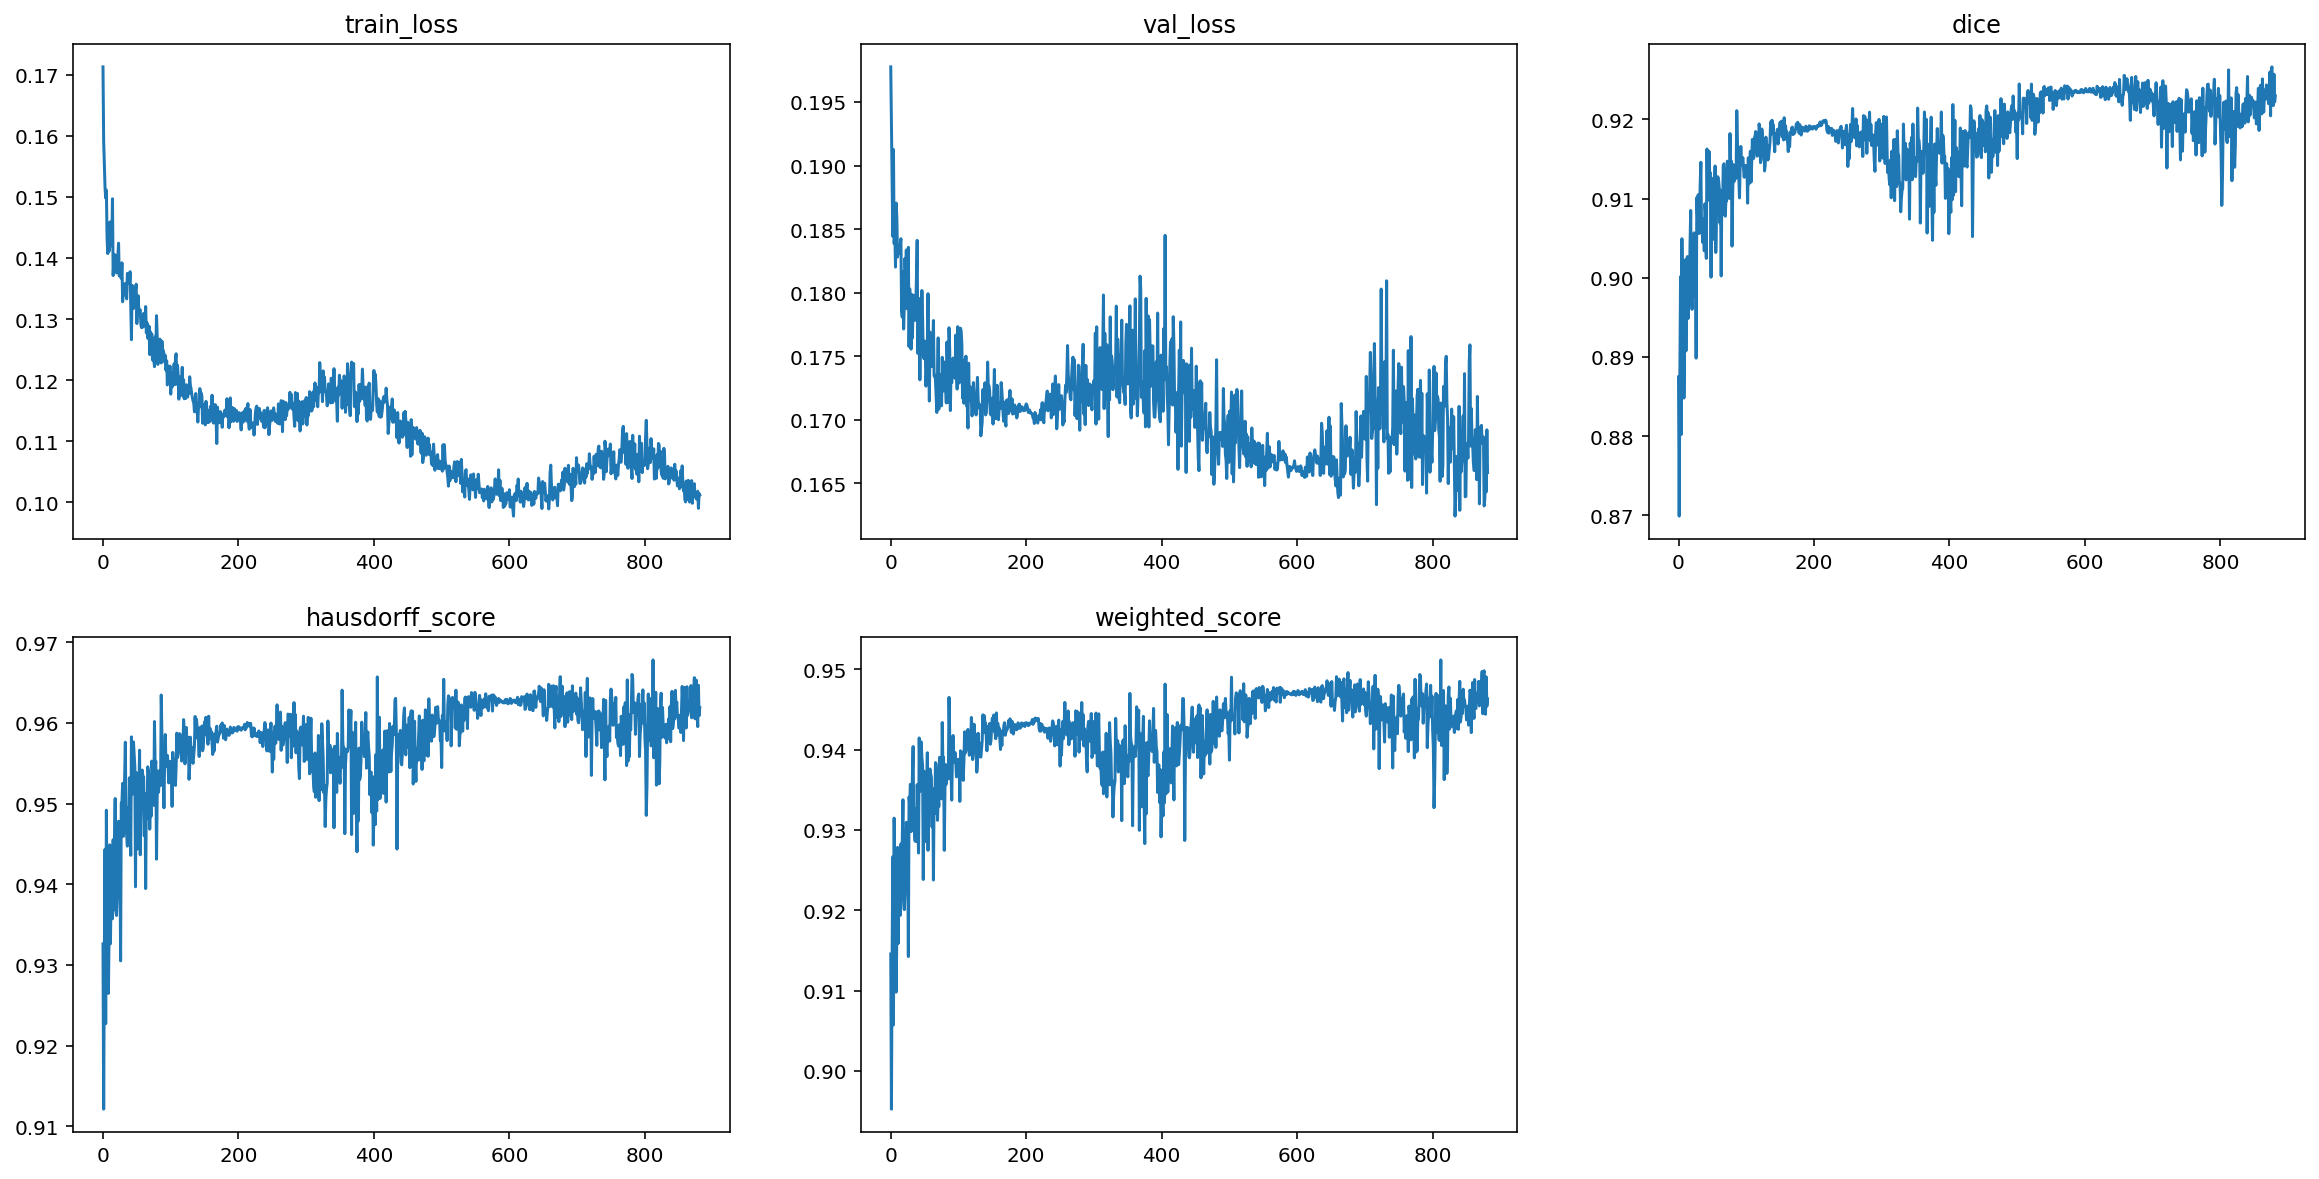

In [36]:
plt.figure(figsize=(20, 10))
labels = [k for k, v in scores.items()]
for i in range(len(labels)):
    plt.subplot(2, 3, i + 1)
    plt.title(labels[i])
    plt.plot(scores[labels[i]])
plt.show();